# Оценка модели и уточнения



<h2>Table of Contents</h2>
<ul>
<li> <a href="#ref1"> оценка модели </a> </li>
    <li> <a href="#ref2"> переобучение, недооценка и выбор модели </a> </li>
    <li> <a href="#ref3"> регрессии гребня </a> </li>
    <li> <a href="#ref4"> Поиск по сетке (Grid search) </a> </li>
</ul>


In [2]:
#! mamba install pandas==1.3.3 -y
#! mamba install numpy=1.21.2 -y
#! mamba install sklearn=0.20.1 -y
#! mamba install   ipywidgets=7.4.2 -y

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# загружаем анализируемый csv
path = 'C:/Users/admin/Desktop/python repo/DataAnalysis/analisys for prediction/Labs/clean_df.csv'
df = pd.read_csv(path)

Во -первых, давайте используем только числовые данные:


In [4]:
# получаем для анализа только числовые столбцы
df = df._get_numeric_data()
#  проверяем
df.head()

,Unnamed: 0,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,...,compression-ratio,horsepower,peak-rpm,price,city-L/100km,highway-L/100km,fuel-type-diesel,fuel-type-gas,aspiration-std,aspiration-turbo
0,0,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,...,9.0,111,5000.0,13495.0,11.190476,8.703704,0,1,1,0
1,1,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,...,9.0,111,5000.0,16500.0,11.190476,8.703704,0,1,1,0
2,2,1,122,94.5,0.822681,0.909722,0.876254,2823,152,2.68,...,9.0,154,5000.0,16500.0,12.368421,9.038462,0,1,1,0
3,3,2,164,99.8,0.848630,0.919444,0.908027,2337,109,3.19,...,10.0,102,5500.0,13950.0,9.791667,7.833333,0,1,1,0
4,4,2,164,99.4,0.848630,0.922222,0.908027,2824,136,3.19,...,8.0,115,5500.0,17450.0,13.055556,10.681818,0,1,1,0


In [5]:
# при прогрузке ссв иногда появляются лишние столбцы unnamed их нужно удалять
df.drop("Unnamed: 0", axis = 1, inplace=True)
df.head(2)

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,price,city-L/100km,highway-L/100km,fuel-type-diesel,fuel-type-gas,aspiration-std,aspiration-turbo
0,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,2.68,9.0,111,5000.0,13495.0,11.190476,8.703704,0,1,1,0
1,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,2.68,9.0,111,5000.0,16500.0,11.190476,8.703704,0,1,1,0


Библиотеки для графиков:


In [6]:
from ipywidgets import interact, interactive, fixed, interact_manual

<h2> функции для построения </h2>
Этот код определяет функцию с именем DistributionPlot, которая принимает две функции (RedFunction и BlueFunction), два названия (RedName и BlueName) и заголовок (Title). Он создает фигуру с заданной шириной и высотой, строит распределения двух функций с помощью функции distplot из библиотеки seaborn, устанавливает заголовок и подписи для графика, а затем отображает и закрывает фигуру.
В целом, можно не вставлять никаких функция а писать код каждый раз новый, это не принципиально, но запуская функцию можно добавить ввод в x и у лэйблы с консоли

In [7]:
# Определение функции DistributionPlot с входными параметрами: RedFunction, BlueFunction, RedName, BlueName и Title
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    # Задание ширины и высоты фигуры
    plt.figure(figsize=(width, height))
    # Создание новой фигуры с указанной шириной и высотой
    
    # Построение распределения RedFunction и BlueFunction с помощью функции kdplot из библиотеки seaborn
    # Установка цвета графика RedFunction на красный, а BlueFunction на синий
    # Присвоение объектов осей графиков переменным ax1 и ax2 соответственно
    ax = sns.kdeplot(RedFunction, color="r", label=RedName)
    ax = sns.kdeplot(BlueFunction, color="b", label=BlueName)
    
    # Установка заголовка графика
    plt.title(Title)
    plt.legend()
    
    # Отображение графика и закрытие фигуры
    plt.show()
    plt.close()


In [8]:
def PollyPlot(xtrain, xtest, y_train, y_test, lr, poly_transform):
    # Устанавливаем размер графика
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    # Находим максимальное и минимальное значения x для построения графика
    xmax = max([xtrain.values.max(), xtest.values.max()])
    xmin = min([xtrain.values.min(), xtest.values.min()])

    # Создаем массив значений x с шагом 0.1 в диапазоне от xmin до xmax
    x = np.arange(xmin, xmax, 0.1)

    # Рисуем точки обучающего набора данных (красные точки)
    plt.plot(xtrain, y_train, 'ro', label='Training Data')

    # Рисуем точки тестового набора данных (зеленые точки)
    plt.plot(xtest, y_test, 'go', label='Test Data')

    # Предсказываем значения y для значений x с помощью модели lr и полиномиального преобразования poly_transform
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')

    # Устанавливаем пределы по оси y
    plt.ylim([-10000, 60000])

     # Добавляем легенду
    plt.legend()

<h2 id = "ref1"> Часть 1: Обучение и тестирование </h2>

<p> Важным шагом в тестировании вашей модели является разделение ваших данных на данные обучения и тестирования.Мы поместим целевые данные <b> Цена </b> в отдельный DataFrame <b> y_data </b>: </p>


In [9]:
y_data = df['price']

положим все незапвисимые переменные в DataFrame **x_data**, то есть просто удалим цену(зависимую переменную с датасета и присвоим его x_data):


In [10]:
x_data=df.drop('price',axis=1)

Теперь мы случайным образом разделяем наши данные на данные обучения и тестирования, используя функцию <b> train_test_split </b>.



In [11]:
#импортируем функицю train_test_split из модуля model_selection библиотеки sklearn
from sklearn.model_selection import train_test_split

# разделяем x_data на x_train, x_test и y_data на y_train, y_test с помощью этой функции, в пропорции 10 на тестирование и на 90 тренировку
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=1, shuffle = True)

# возвращает количество строк (примеров) в массиве x_test, которое представляет количество тестовых примеров. 
print("number of test samples :", x_test.shape[0])
# возвращает количество строк (примеров) в массиве x_train, которое представляет количество тренировочных примеров.
print("number of training samples:",x_train.shape[0])
# Примечание: логично что тестовых образцов по х и по у одинаково, поэтому нет смысла выводить данные по двум осям


number of test samples : 20
number of training samples: 179


Параметр <b> test_size </b> устанавливает долю данных, которые разделены на набор тестирования.В вышеперечисленном набор тестирования составляет 10% от общего набора данных. 


**НАПРИМЕР:**

Если у вас есть 100 строк наблюдений и вы используете функцию train_test_split с параметром test_size=0.10, то переменная x_train будет содержать 90% (то есть 90 строк) из датафрейма x_data, а переменная x_test будет содержать оставшиеся 10% (то есть 10 строк).

Таким образом, в переменной x_train будет храниться 90 строк из датафрейма x_data. Переменные y_train и y_test будут содержать соответствующие целевые значения для этих строк.

Функция train_test_split используется для разделения данных на обучающую и тестовую выборки. 
Параметр test_size указывает, какую долю данных вы хотите выделить для тестовой выборки. В данном случае, с параметром test_size=0.10, 10% данных будут использоваться для тестирования, а оставшиеся 90% будут использоваться для обучения модели.
В ходе экспериментов было выяснено что в функцию train_test_split включается shuffle = True по умолчанию, которая перемешивает строкиБ если установить False - то тренировочный сет получит последние 10 строц строк датасета так как деление 90 на 10)

Если вы замените x_train1.shape[0] на x_train1.shape[1], то будет выведено количество признаков (столбцов) в обучающей выборке, а не количество образцов (строк). 

Если вы использовать параметр random_state = 1 при разделении данных на обучающую и тестовую выборки, то разделение будет происходить с использованием одного и того же случайного состояния. 

Это означает, что при каждом запуске кода с random_state=1 вы будете получать одно и то же разделение данных на обучающую и тестовую выборки, аналогично и с другими числами, но перемешивание будет по другому алгоритму.

**То есть. выборка с random state = 1 будет рандомная но каждый раз одинаковая, в то время как выброка random state =2 будет всегда идентична, но отлична от выборки 1**

Например, если вы используете функцию train_test_split с параметром test_size=0.2 и random_state=1, то каждый раз, когда вы запускаете код, 80% данных будут использоваться для обучения модели, а 20% данных будут использоваться для тестирования модели, и это разделение будет одинаковым при каждом запуске.

Таким образом, использование random_state = целому числу (например 1) обеспечивает воспроизводимость разделения данных на обучающую и тестовую выборки при каждом запуске кода. Это может быть полезно, если вам нужно получить одинаковое разделение данных для сравнения моделей или повторяемости результатов. 

Если вам не требуется воспроизводимость результатов и вам просто нужно случайное разделение данных, вы можете установить random_state на любое целое число или оставить его без изменений (по умолчанию random_state=None). Это приведет к каждый раз случайному разделению данных.

In [12]:
# посмотрим инфу про эту функцию
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets.
    
    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, y))``, and application to input data
    into a single call for splitting (and optionally subsampling) data into a
    one-liner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to

В этом примере мы генерируем 5 разных разделений данных, используя разные значения random_state от 0 до 4. Это позволяет вам оценить стабильность модели на разных разделениях данных.

В целом, выбор оптимального значения random_state зависит от вашей конкретной задачи и требований. Рекомендуется провести несколько экспериментов с разными значениями random_state и выбрать то, которое дает наилучшие результаты для вашей модели.

In [13]:
#  в тестовую выборку попали следующие строки
x_test.head(20)

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-L/100km,highway-L/100km,fuel-type-diesel,fuel-type-gas,aspiration-std,aspiration-turbo
175,-1,122,104.5,0.902451,0.923611,0.904682,3151,161,3.27,3.35,9.2,156,5200.0,12.368421,9.791667,0,1,1,0
40,0,85,96.5,0.842864,0.905556,0.904682,2465,110,3.15,3.58,9.0,101,5800.0,9.791667,8.392857,0,1,1,0
34,0,110,96.5,0.785199,0.888889,0.911371,2010,92,2.91,3.41,9.2,76,6000.0,7.833333,6.911765,0,1,1,0
90,1,103,94.5,0.817876,0.886111,0.894649,2024,97,3.15,3.29,9.4,69,5200.0,7.580645,6.351351,0,1,1,0
145,1,87,95.7,0.762614,0.883333,0.911371,2040,92,3.05,3.03,9.0,62,4800.0,7.580645,6.184211,0,1,1,0
182,2,94,97.3,0.825084,0.909722,0.931438,2300,109,3.19,3.40,10.0,100,5500.0,9.038462,7.343750,0,1,1,0
95,2,168,95.1,0.780394,0.886111,0.891304,2008,97,3.15,3.29,9.4,69,5200.0,7.580645,6.351351,0,1,1,0
4,2,164,99.4,0.848630,0.922222,0.908027,2824,136,3.19,3.40,8.0,115,5500.0,13.055556,10.681818,0,1,1,0
29,2,137,86.6,0.694858,0.887500,0.849498,1713,92,2.91,3.41,9.6,58,4800.0,4.795918,4.351852,0,1,1,0
167,-1,65,102.4,0.843825,0.923611,0.918060,2326,122,3.31,3.54,8.7,92,4200.0,8.103448,6.911765,0,1,1,0


## Давайте импортируем <b> linearregression </b> из модуля <b> linear_model </b>.


In [14]:
from sklearn.linear_model import LinearRegression

Мы создаем объект линейной регрессии:


In [15]:
lre=LinearRegression()

Мы подгоняем  модель, используя функцию «Мощность лошадиных сил»:


In [16]:
# обучаем на столбце и тренировочных данных (90 проц данных)
lre.fit(x_train[['horsepower']], y_train)

LinearRegression()

Давайте рассчитаем r^2 на тестовых данных:


In [17]:
# к объекту линейной регрессии lre применим функцию score(x,y) и положим в качестве аргументов из 
# фрейма данных для тестирования возьмем столбец "horsepower", в качестве х-параметра и y-параметр из датафрейма y_test
lre.score(x_test[['horsepower']], y_test)

0.5388443337445994

In [18]:
# расчитаем R^2 для фрейма тренировочных данных используя те же параметры
lre.score(x_train[['horsepower']], y_train)

0.6555834266833747

Мы видим, что r^2 намного меньше, при использовании тестовых данных, чем при использовании тренировочных, напомню себе что R^2 должен приближаться к 1 для идеального соответствия
0.65 обозначает что только 65 процентов дисперсии объясняется моделью

<b>
Найдите R^2 в тестовых данных, используя 40% набора данных для тестирования.
</b>
</div>


In [19]:
# разделяем x_data на x_train, x_test и y_data на y_train, y_test с помощью этой функции, в пропорции 40 на тестирование и на 60 тренировку
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.4, random_state=0) 
# возвращает количество строк (примеров, наблюдений) в массиве x_test1, которое представляет количество тестовых примеров. 
print("number of test samples X and Y (rows):", x_test1.shape[0])
# возвращает количество строк (примеров, наблюдений) в массиве x_train1, которое представляет количество тренировочных примеров.
print("number of training samples X and Y (rows):",x_train1.shape[0])
# Примечание. Это я делала ранее
#  подгоняем модель
lre.fit(x_train1[['horsepower']],y_train1)
# снова считаем R^2 
lre.score(x_test1[['horsepower']],y_test1)


number of test samples X and Y (rows): 80
number of training samples X and Y (rows): 119


0.7057658850189669

Иногда у вас нет достаточных данных тестирования;

В результате вы можете выполнить перекрестную проверку.

Давайте рассмотрим несколько методов, которые вы можете использовать для перекрестной проверки.

<h2>Оценка перекрестной проверки</h2>


Давайте импортируем <b> model_selection </b> из модуля <b> cross_val_score </b>.


In [20]:
from sklearn.model_selection import cross_val_score

Rcross - Это переменная, в которую сохраняются значения оценок (score) модели для каждого фолда. Каждое значение в Rcross представляет собой оценку модели на соответствующем фолде.

cross_val_score - Эта функция из модуля sklearn.model_selection используется для выполнения кросс-валидации модели. Она принимает модель (lre), признаки (x_data[['horsepower']]), целевую переменную (y_data) и параметр cv=4, который указывает на использование 4-х фолдов ***(каждый фолд это 100 проц данных/на количество фолдов).***

Фолды в кросс-валидации представляют собой разделение обучающего набора данных на равные части. Каждый фолд используется в качестве тестового набора данных, а остальные фолды объединяются в обучающий набор данных. Процесс повторяется для каждого фолда, чтобы каждый фолд был использован в качестве тестового набора данных.

Количество фолдов влияет на кросс-валидацию следующим образом:

1. Большее количество фолдов (например, 10) обеспечивает более точную оценку производительности модели, так как каждый фолд будет использоваться в качестве тестового набора данных, и модель будет оцениваться на разных наборах данных. Однако это требует большего времени для выполнения, так как модель должна быть обучена и оценена для каждого фолда.

2. Меньшее количество фолдов (например, 3) может быть полезно, если у вас ограниченное количество данных или если обучение модели требует значительного времени. Однако оценка производительности модели может быть менее точной, так как модель будет оцениваться только на нескольких наборах данных.

Обычно рекомендуется использовать 5 или 10 фолдов для кросс-валидации, чтобы достичь баланса между точностью оценки и временем выполнения. Однако это может варьироваться в зависимости от конкретной задачи и доступных данных.

**К примеру:**

 если у вас есть датасет с 100 наблюдениями и вы используете параметр cv=4, то ваш датасет будет разделен на 4 фолда. Каждый фолд будет содержать 25 наблюдений. 
Кросс валидация, это итерационный процесс

- В первой итерации кросс-валидации первый фолд будет использоваться в качестве тестового набора данных, **а остальные три фолда объединятся в обучающий набор данных.** 
- Затем модель будет обучаться на обучающем наборе и оцениваться на тестовом наборе. 
- Этот процесс повторяется для каждого фолда, чтобы каждый фолд был использован в качестве тестового набора данных.

Таким образом, в результате кросс-валидации вы получите 4 оценки производительности модели, которые можно усреднить для получения общей оценки.

In [111]:
# выполняем кросс-валидацию модели линейной регрессии на признаке horsepower и целевой переменной y_data 
# с использованием 4-х фолдов, и сохраняет оценки модели для каждого фолда в переменную Rcross.
Rcross = cross_val_score(lre, x_data[['horsepower']], y_data, cv=4)
# кроссвалидацию можно использовать на всем наборе данных признаков и целевых переменных. оно разделяет данные само и поочередно тренируется и тестирует

По умолчанию объект кросс валидации вернет оценку r^2.
Каждый элемент в массиве имеет среднее значение r^2 для одного фолда данных:


In [112]:
#  массив значений r2 при использовании различных комбинаций фолдов
Rcross

array([0.77344651, 0.53291315, 0.72007907, 0.04475435])

Мы можем рассчитать среднее и стандартное отклонение нашей оценки, так как это является основной целью кросс валидации - найти средний показатель:

Метод cross_val_score используется для оценки эффективности модели путем вычисления оценки качества (например, R2-коэффициента) на каждом фолде кросс-валидации и возвращения массива этих оценок. Это позволяет оценить среднюю эффективность модели на всем наборе данных.


In [113]:
#  применим к объекту кросс валидации функции mean() и std()
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

The mean of the folds are 0.5177982696090335 and the standard deviation is 0.28734672370921965


Мы можем использовать отрицательную квадратичную ошибку в качестве оценки, установив параметр «оценка» метрики для `'neg_mean_squared_error'`.
1. `cross_val_score(lre, x_data[['horsepower']], y_data, cv=4, scoring='neg_mean_squared_error')` - это вызов функции `cross_val_score`, которая выполняет кросс-валидацию модели. 

Она принимает модель lre, признаки `x_data[['horsepower']]`, целевую переменную y_data и параметр cv=4, указывающий на использование 4-х фолдов. 

Параметр `scoring='neg_mean_squared_error'` указывает на использование среднеквадратичной ошибки (MSE) в качестве метрики оценки модели.

2. `-1 * ... - это умножение результата cross_val_score на -1`. Это делается для того, чтобы преобразовать метрику оценки (среднеквадратичная ошибка) в отрицательное значение. 

В некоторых случаях, когда функция cross_val_score использует метрику оценки, чем выше значение метрики, тем лучше модель. 

Однако, в данном случае, мы хотим минимизировать среднеквадратичную ошибку, поэтому умножаем на -1, чтобы получить положительное значение ошибки.


In [131]:
# Аналогично MSE = -Rcross
Folds_MSE = -1 * cross_val_score(lre, x_data[['horsepower']], y_data, cv=4, scoring='neg_mean_squared_error')
print('MSE для всех фолдов', Folds_MSE)

# Выведем минимальную MSE - лучший параметр
print(f'Минимальная MSE = ', min(Folds_MSE))

# Выведем MSE для каждого фолда
for fold_num, Folds_MSE in enumerate(Folds_MSE):
    print("Fold", fold_num + 1, "error:", Folds_MSE)


MSE для всех фолдов [20533117.27752145 42791870.87475634 13888093.22978046 17774689.32906011]
Минимальная MSE =  13888093.229780464
Fold 1 error: 20533117.277521454
Fold 2 error: 42791870.87475634
Fold 3 error: 13888093.229780464
Fold 4 error: 17774689.32906011


мы получим массив оценок среднеквадратичной ошибки для каждого фолда в кросс-валидации, преобразованных в положительные значения. Это позволяет нам оценить производительность модели и сравнить ее с другими моделями или параметрами.
Каждое число в массиве представляет собой оценку среднеквадратичной ошибки для соответствующего фолда в кросс-валидации.

Чтобы проинтерпретировать эти значения, нужно помнить, что **среднеквадратичная ошибка измеряет разницу между фактическими значениями и предсказанными значениями модели. Чем меньше значение среднеквадратичной ошибки, тем лучше модель.**

В данном случае, значения ошибки варьируются от примерно 13,888,093 до 42,791,870. Чем меньше значение ошибки, тем ближе предсказания модели к фактическим значениям. Следовательно, на основе этих результатов можно сделать вывод, 
что модель имеет наилучшую производительность для третьего фолда (с наименьшей ошибкой) и наихудшую производительность для второго фолда (с наибольшей ошибкой).

Общая оценка производительности модели может быть получена путем усреднения этих значений.

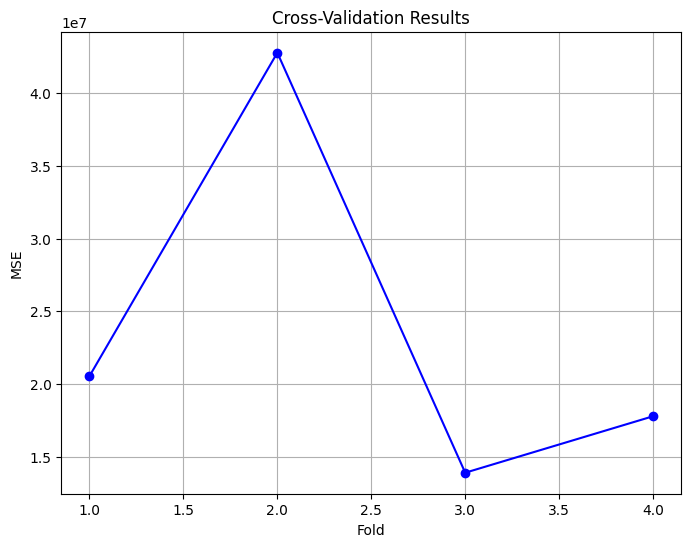

In [ ]:
Folds_MSE = -1 * cross_val_score(lre, x_data[['horsepower']], y_data, cv=4, scoring='neg_mean_squared_error')
# Создаем график
plt.figure(figsize=(8, 6))
# количество фолдов должно быть равно количеству рэнджей
plt.plot(range(1, 5), Folds_MSE, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('Cross-Validation Results')
plt.grid(True)
plt.show()

**В идеале, при кросс-валидации все фолды должны показывать примерно одинаковую ошибку. Это означает, что модель имеет одинаковую способность обобщения и хорошую устойчивость к вариациям в данных. Однако, в реальности могут возникать небольшие различия в ошибках между фолдами из-за случайного разделения данных или наличия особенностей в конкретных подвыборках. Важно следить за стабильностью ошибки при кросс-валидации и, при необходимости, проводить дополнительный анализ**

В таком случае, вы можете принять различные меры:

1. Убедитесь, что ваш набор данных достаточно представительный и разнообразный. Если данные во втором фолде не подходят для обучения модели, это может быть результатом нерепрезентативных или несбалансированных данных. В таком случае, важно обратить внимание на корректность вашего набора данных.

2. Оцените другие метрики производительности модели, такие как средняя ашибка (MAE), коэффициент детерминации (R^2) или другие, чтобы получить более полную картину эффективности модели на всех фолдах.

3. Если различия в ошибках между разными фолдами слишком велики, это может быть признаком переобучения модели. В таком случае, у вас есть несколько вариантов действий, таких как изменение сложности модели, регризации или увеличение объема данных для обучения.

4. Обратите разбиение данных при кросс-валидации. Возможно, текущее разбиение не является оптимальным. Попробуйте изменить количество фолдов или использовать другие стратегии разбиения, такие как стрицированная кросс-валидация.

В целом, анализ результатов кросс-валидации может помочь вам понять, как ваша модель работает на разных фолдах и подсказывает, какие дополнительные шаги можно предпринять для улучшения ее эффективности и надежности.

<b>
Рассчитайте средний r^2, используя 10  фолдов (cv=10), затем найдите средний r^2 для этих фолдов, используя параметр «лошадиные силы»:
</b>
</div>


In [141]:
# 1 фолд 50 проц данных и 2 фолд 50 проц
Rc = cross_val_score(lre,x_data[['horsepower']], y_data, cv=10)
for i in range(len(Rc)):
# Выведем массив оценок r^2
    print(f'r^2 для {i} фолда =', Rc[i])




r^2 для 0 фолда = 0.5815773340569337
r^2 для 1 фолда = -1.4279260758176648
r^2 для 2 фолда = 0.8873920151424207
r^2 для 3 фолда = 0.34744029400900844
r^2 для 4 фолда = -1.2213317960925738
r^2 для 5 фолда = -0.14220573861275
r^2 для 6 фолда = 0.8796641829204142
r^2 для 7 фолда = -1.1390350369201512
r^2 для 8 фолда = -1.427916778760328
r^2 для 9 фолда = 0.1969914064685936


In [ ]:
# Выведем среднее этих 2 оценок r^2
print('Среднее значение всех r^2 массива =', Rc.mean())

Массив среднеквадратичных ошибок [33974345.50969519  7165239.95684226  9780098.61498028 98300221.13138713
 17312282.55261689 22677667.51204153 10160132.33760024  4062393.33149303
 23910282.59173068 15162205.06407104]
Стандартное отклонение MSE 26112519.269398507


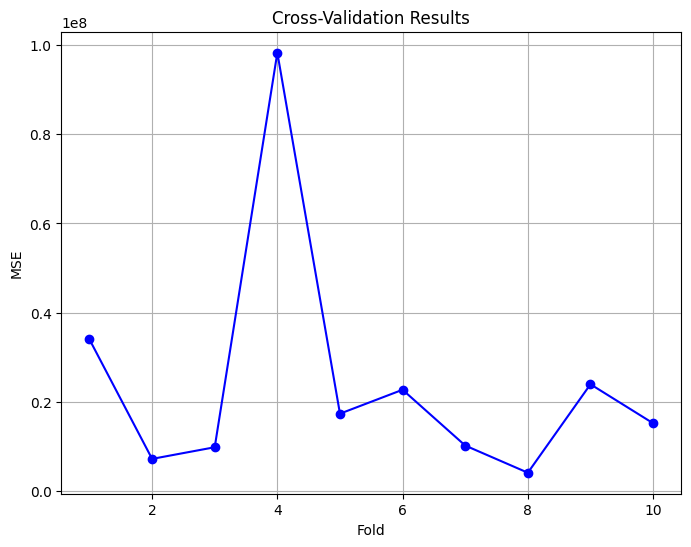

In [146]:
# Преобразуем отрицательные значения MSE в положительные
mse_scores = -1 * cross_val_score(lre, x_data[['horsepower']], y_data, cv=10, scoring='neg_mean_squared_error')
print("Массив среднеквадратичных ошибок",mse_scores)
print("Стандартное отклонение MSE", mse_scores.std())
# Создаем график
plt.figure(figsize=(8, 6))
# количество фолдов должно быть равно количеству рэнджей
plt.plot(range(1, 11), mse_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('Cross-Validation Results')
plt.grid(True)
plt.show()

Полученные значения среднеквадратичной ошибки (MSE) для каждого из 10 фолдов указывают на различную точность предсказаний модели при применении к разных наборах данных. Стандартное отклонение MSE предоставляет меру распределения ошибок вокруг их среднего значения.

Как видно из значений MSE, разброс величины ошибки достаточно широкий. может указывать на неоднородность или несбалансированность данных в разных фолдах. Более высокие значения MSE могут указывать на более сложные или нелинейные соотношения между переменными в данных.

## ПРИМЕЧАНИЕ:
***Если вы используете функцию cross_val_score с параметром cv=2 для деления на 2 фолда, то деление будет происходить последовательно, а не случайным образом. Первые 50 наблюдений будут в первом фолде, а оставшиеся 50 наблюдений будут во втором фолде.***

***При последовательном делении на фолды, каждый фолд будет содержать примерно одинаковое количество наблюдений. В вашем случае, если у вас есть 100 наблюдений и вы делите на 2 фолда, то каждый фолд будет содержать примерно 50 наблюдений.***

Однако, если вам требуется случайное деление на фолды, вы можете использовать функцию **KFold** из модуля **sklearn.model_selection**. Вот пример кода, который позволит вам случайным образом разделить данные на 2 фолда:

<code>

from sklearn.model_selection import KFold

import numpy as np

data = np.arange(100)  # Пример данных с 100 наблюдениями

kfold = KFold(n_splits=2, shuffle=True)


for train_index, test_index in kfold.split(data):

    train_data = data[train_index]

    test_data = data[test_index]

    print("Train data:", train_data)

    print("Test data:", test_data)
    
    print()

</code>
В этом примере мы используем KFold с параметром n_splits=2 для деления на 2 фолда. Параметр shuffle=True гарантирует случайное разделение данных на фолды. В каждой итерации цикла for, мы получаем индексы для тренировочного и тестового наборов данных (train_index и test_index соответственно), и затем используем эти индексы для получения соответствующих данных из исходного набора данных.

Таким образом, вы можете использовать KFold с параметром shuffle=True, чтобы случайным образом разделить данные на фолды

**Вы также можете использовать функцию «cross_val_predict» для прогнозирования вывода.**

Функция разбивает данные в указанное количество фолдов, с одним из них для тестирования, а другие фолды используются для обучения.

Метод cross_val_predict используется для получения предсказаний модели на каждом фолде кросс-валидации. Он возвращает массив предсказанных значений для каждого объекта входных данных. Это позволяет оценить, насколько хорошо модель предсказывает значения на новых данных, которые она ранее не видела.


In [26]:
from sklearn.model_selection import cross_val_predict

Мы вводим объект, который назовем yhat, 

применим функцию cross_val_predict, которая примет параметры: <b> 

- объект линейной регрессии lre
- признак «лошадиные силы» </b> 
- целевые данные <b> y_data </b>.
- Параметр 'cv' определяет количество фолдов.
В этом случае это 4. 



In [27]:
yhat = cross_val_predict(lre, x_data[['horsepower']], y_data, cv=4)
# Выведем объекты с 1 по 5 (слайс)
yhat[0:5]

array([14184.73813347, 14184.73813347, 20864.83116721, 12786.57912641,
       14806.14213661])

Код yhat = cross_val_predict(lre, x_data[['horsepower']], y_data, cv=4) выполняет кросс-валидацию модели lre на признаках x_data[['horsepower']] 
и целевой переменной y_data с использованием 4 фолдов. 

Результатом будет массив yhat, содержащий **предсказанные значения целевой переменной**, которой является цена (y из y_data) для каждого наблюдения.

Чтобы вывести первые 5 элементов массива yhat, то есть предсказанные цены для 5 пяти строк y_data, используется срез [0:5]. 

Тоесть модель проанализировала, сколько может стоить автомобиль исходя из показателя horsepower


Размерность предсказанных значений yhat (90,) меньше размерности фактических значений y_data (199) по причине использования кросс-валидации с параметром cv=4.

<code>

yhat.shape

y_data.shape
</code>

При использовании кросс-валидации, данные разбиваются на cv фолдов (в данном случае 4 фолда). Каждый фолд последовательно выступает в качестве тестового набора данных, на котором модель делает предсказания, в то время как остальные фолды используются для обучения модели. Таким образом, для каждого фолда будет получено набор предсказанных значений.

В данном случае, при использовании cross_val_predict с cv=4, модель делает предсказания на каждом из 4 фолдов, и в итоге получается массив предсказанных значений размером 90 (199 / 4 = 49.75, округлено до 90).

Обратите внимание, что количество предсказанных значений будет зависеть от выбранного значения параметра cv в функции cross_val_predict. Если вы хотите получить предсказания для всех объектов данных, вы можете использовать кросс-валидацию с параметром cv равным количеству объектов данных, то есть cv=len(x_data).

In [117]:
yhat = cross_val_predict(lre, x_data[['horsepower']], y_data, cv=len(x_data))
# Выведем объекты с 1 по 5 (слайс)
yhat[0:5]

array([14558.28212409, 14542.47685195, 22036.17550185, 12998.07241535,
       15229.31399486])

In [118]:
from sklearn.metrics import r2_score

# Compute R2 score between predicted values and actual values
r2 = r2_score(y_data, yhat)
print("R2 score:", r2)

R2 score: 0.6461952849080959


<h2 id = "ref2"> Часть 2: Пререобучение, недостаток и выбор модели </h2>

<p> Оказывается, что данные тестирования, иногда называемые «вне выборки данных», являются гораздо лучшей мерой того, насколько хорошо ваша модель работает в реальном мире.Одной из причин этого является переосмысление.

Давайте рассмотрим несколько примеров.Оказывается, эти различия более очевидны при множественной линейной регрессии и полиномиальной регрессии, поэтому мы рассмотрим переосмысление в этом контексте. </P>


### Давайте создадим объектлинейной регрессии и тренируем модель, используя параметры <b> 'лошадиные силы' </b>, <b> 'curb-weight' </b>, <b> 'size' </b> и <b> 'highway-L/100km' </b>


In [28]:
df.head(1)

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,price,city-L/100km,highway-L/100km,fuel-type-diesel,fuel-type-gas,aspiration-std,aspiration-turbo
0,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,2.68,9.0,111,5000.0,13495.0,11.190476,8.703704,0,1,1,0


In [29]:
lr = LinearRegression()
#обучим модель на мультипараметрах из тренировочного сета данных
# Напомню себе, что x_train содержит 90 проц строк с независимыми переменными датасета, а y_train 90 проц строк с ценами(зависимая переменная) 
# (x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=1) )
lr.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']], y_train)

# mylty_paramethers_x_train=x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']]
# lr.fit(mylty_paramethers_x_train, y_train)

LinearRegression()

обычно мы обучаем модель на тренировочных данных (train) и затем используем ее для предсказания значений на тестовых данных (test). 
Это позволяет оценить производительность модели на новых, ранее не виденных данных. Таким образом, мы можем проверить, насколько хорошо модель обобщает свои знания на новые примеры.

### Прогноз с использованием учебных данных:


In [30]:
# положим массив предсказанныe цены, исходя из модели линейной регрессии, обеченной на мультипараметрах из тренировочной выборки
yhat_train = lr.predict(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']])
# выведем 5 элементов от 1 до 5 (слайс)
yhat_train[0:5]

array([ 5742.01110276, 28459.52974018, 34866.62289736,  6438.88475849,
        3747.80413831])

### Прогноз с использованием тестовых данных:


In [31]:
# положим массив предсказанныe цены, исходя из модели линейной регрессии, обеченной на мультипараметрах из тестовой выборки
yhat_test = lr.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']])
yhat_test[0:5]

array([21232.5004059 , 11434.21114518,  6613.10093819,  6646.09517908,
        5936.17262749])

Давайте выполним некоторую оценку модели, используя наши данные обучения и тестирования отдельно.Во -первых, мы импортируем библиотеку Seaborn и Matplotlib для заговора.


In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Давайте рассмотрим распределение прогнозируемых значений учебных данных.


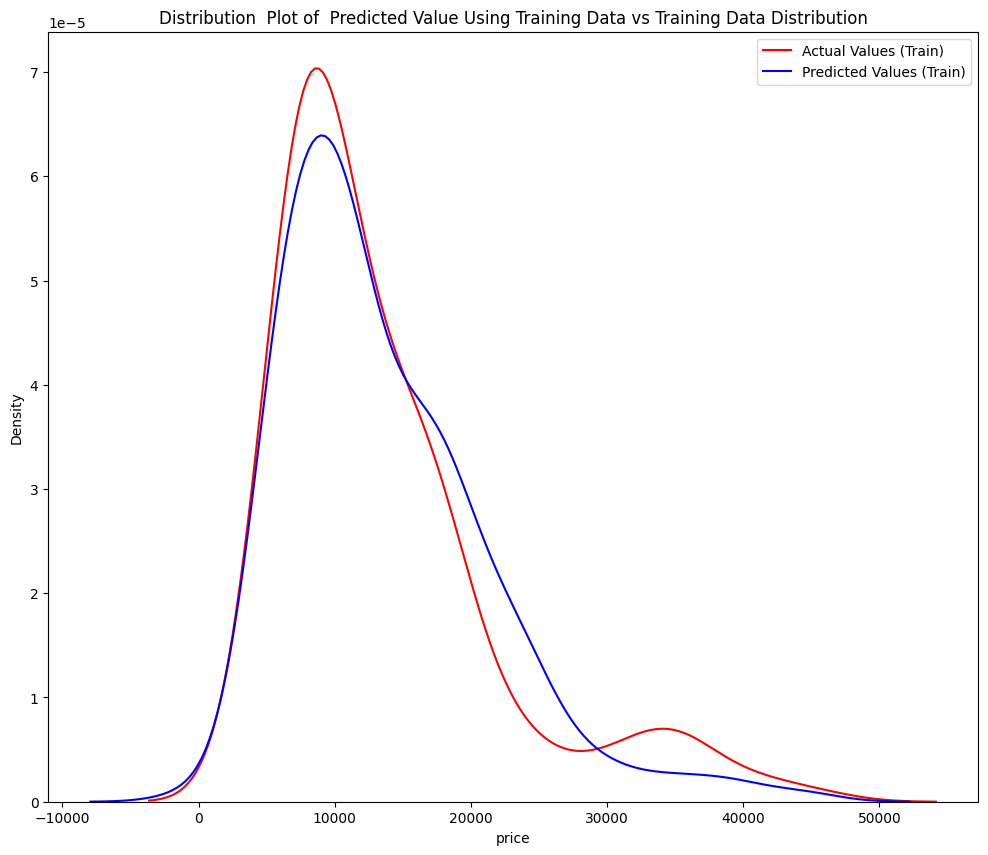

In [33]:
# наша функция принимает наименование таблицы с переменной Title. положим туда наш заголовок
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
# применим функцию графика распределения
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

Рисунок 1: График прогнозируемых значений с использованием учебных данных по сравнению с фактическими значениями учебных данных.


До сих пор модель, кажется, преуспевает в обучении наборе данных обучения.Но что происходит, когда модель встречается с новыми данными из набора данных тестирования?Когда модель генерирует новые значения из тестовых данных, мы видим, что распределение прогнозируемых значений сильно отличается от фактических целевых значений.


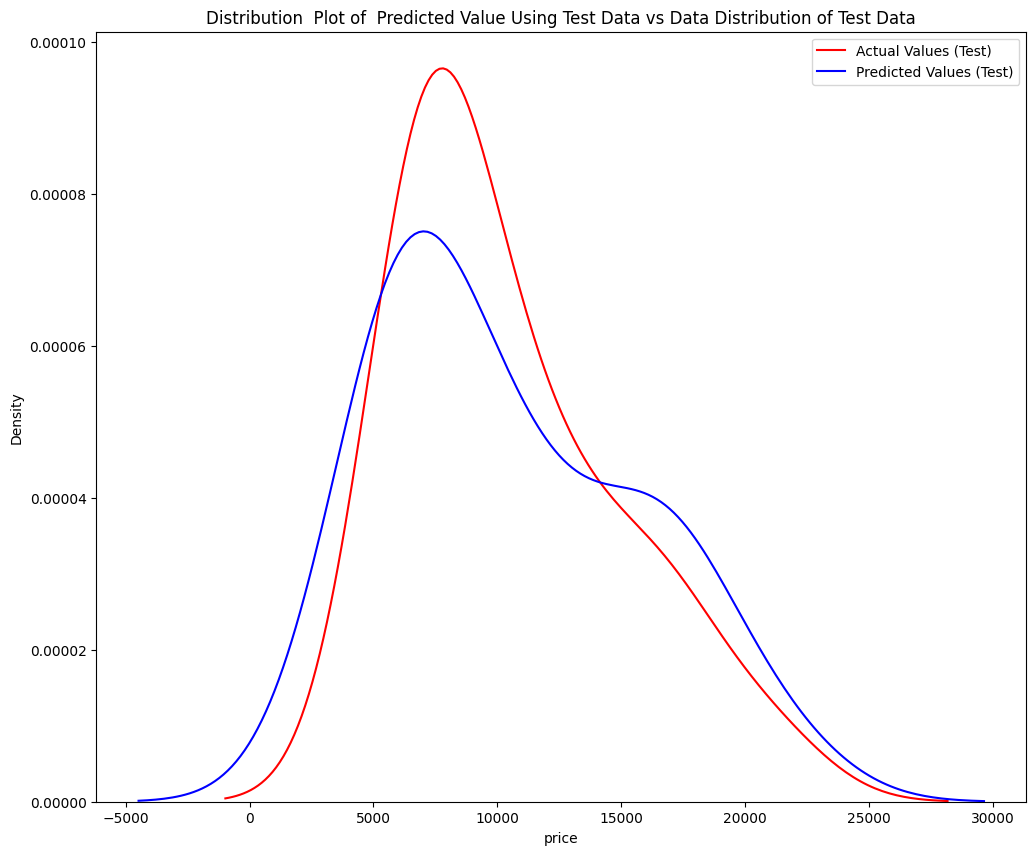

In [34]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

Рисунок 2: График прогнозируемого значения с использованием тестовых данных по сравнению со фактическими значениями тестовых данных.


<p> Сравнивая рисунок 1 и рисунок 2, очевидно, что распределение тестовых данных на рисунке 1 гораздо лучше приспосабливается к данным.
Эта разница на рисунке 2 очевидна в диапазоне от 5000 до 15 000.
Именно здесь форма распределения чрезвычайно отличается.
Давайте посмотрим, если полиномиальная регрессия также демонстрирует падение точности прогнозирования при анализе тестового набора данных. </P>


In [35]:
# импортируем функцию для полиномиальной регрессии
from sklearn.preprocessing import PolynomialFeatures

<h4> ПЕРЕОБУЧЕНИЕ</h4>

при тестировании вашей модели с использованием тестового набора ваша модель может работать плохо, поскольку она моделирует шум, а не основной процесс, который генерировал отношения.

Давайте создадим полиномиальную модель степени 5. </P>

Давайте использовать 55 процентов данных для обучения, а остальное для тестирования (0.45):


In [36]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.45, random_state=0)

Мы выполним полиномиальное преобразование степени 5 на признаке <b>'horsepower'</b>. 

***Пример:***
Если у вас x_train содержит данные [1, 2, 3], и вы применяете pr = PolynomialFeatures(degree=5) с использованием x_train_pr = pr.fit_transform(x_train[[1,2,3]]), то вы получите следующие данные:

<code>
x_train_pr = [
  
  [1, 1, 1, 1, 1, 1],

  [1, 2, 4, 8, 16, 32],

  [1, 3, 9, 27, 81, 243]
  
]
</code>


**Объяснение:**
- x_train содержит данные [1, 2, 3].
- pr.fit_transform(x_train[[1,2,3]]) применяет полиномиальное преобразование степени 5 к данным x_train.
- При преобразовании, каждый элемент в x_train возводится в степени от 0 до 5, чтобы создать новые признаки.
- В результате получается матрица x_train_pr, где каждая строка представляет собой преобразованные признаки для каждого элемента из x_train.
- В данном случае, первый столбец в x_train_pr всегда содержит 1, чтобы учесть свободный член в модели линейной регрессии.
- Второй столбец в x_train_pr содержит значения из x_train в первой степени (1, 2, 3).
- Третий столбец в x_train_pr содержит значения из x_train во второй степени (1, 4, 9).
- И так далее, пока не будет достигнута степень 5.

**Таким образом, после применения полиномиального преобразования степени 5 к данным [1, 2, 3], вы получите матрицу x_train_pr, содержащую новые признаки, учитывающие полиномиальные зависимости между данными и целевой переменной.**

In [37]:
# Импортируем необходимые модули
from sklearn.preprocessing import PolynomialFeatures

# Создаем объект PolynomialFeatures с указанием степени полинома
pr = PolynomialFeatures(degree=5)

# Применяем метод fit_transform на тренировочных данных
# Метод fit_transform выполняет два шага: обучение модели и преобразование данных
x_train_pr = pr.fit_transform(x_train[['horsepower']])

# Применяем метод transform на тестовых данных
# Метод transform выполняет только преобразование данных, используя параметры, вычисленные на тренировочных данных
x_test_pr = pr.transform(x_test[['horsepower']])
# проверим создание объекта
pr

PolynomialFeatures(degree=5)

Метод fit_transform объединяет два шага: обучение модели и преобразование данных. Во время обучения модели, метод анализирует обучающие данные и вычисляет параметры, необходимые для преобразования данных. Затем, используя эти параметры, метод преобразует данные.

Метод fit_transform очень удобен, так как он объединяет два шага в один. Однако, в некоторых случаях, когда у вас уже есть обученная модель, вы можете использовать метод transform, который просто преобразует данные, используя уже вычисленные параметры модели.

**Итак, выше мы проделали следующие шаги:**

1. Импортируем класс PolynomialFeatures из модуля sklearn.preprocessing.
2. Создаем объект pr типа PolynomialFeatures с указанием степени полинома (в данном случае 5).
3. Применяем метод fit_transform на тренировочных данных x_train[['horsepower']]. Этот метод выполняет два шага: обучение модели и преобразование данных. В результате получаем новую матрицу x_train_pr, содержащую полиномиальные признаки степени 5 для столбца 'horsepower' тренировочных данных.
4. Применяем метод transform на тестовых данных x_test[['horsepower']]. Этот метод выполняет только преобразование данных, используя параметры, вычисленные на тренировочных данных. В результате получаем новую матрицу x_test_pr, содержащую полиномиальные признаки степени 5 для столбца 'horsepower' тестовых данных.

Таким образом, код выполняет полиномиальное преобразование данных. Он создает новые признаки путем возведения исходного признака в указанную степень (в данном случае 5). Это может быть полезно, когда исходные данные нелинейно связаны с целевой переменной, и полиномиальные признаки могут помочь модели лучше описать зависимость между признаками и целевой переменной

Теперь давайте создадим модель линейной регрессии «Poly» и обучиим ее на преобразованных в 5 степень полинома и обученных данных а так же на исходных данных зависимой переменной.


In [38]:
# Создаем объект линейной регрессии
poly = LinearRegression()

# Обучаем модель на преобразованных тренировочных данных
poly.fit(x_train_pr, y_train)

LinearRegression()

1. Создаем объект poly типа LinearRegression, который представляет модель линейной регрессии.
2. Вызываем метод fit на объекте poly, передавая в качестве параметров преобразованные тренировочные данные x_train_pr и исходные тренировочные целевые значения y_train.
3. Обучение модели линейной регрессии происходит на преобразованных данных x_train_pr, потому что мы предварительно применили полиномиальное преобразование к признаку 'horsepower'. Это позволяет модели учесть нелинейные зависимости между признаками и целевой переменной.
4. Исходные тренировочные целевые значения y_train остаются без изменений, так как они представляют собой исходные значения, которые мы хотим предсказать с помощью обученной модели.

Таким образом, объект линейной регрессии обучается на преобразованных данных x_train_pr и исходных целевых значениях y_train, чтобы найти оптимальные коэффициенты модели, которые наилучшим образом соответствуют зависимости между признаками и целевой переменной.

Мы можем увидеть выходные спрогнозированные данные нашей модели, используя метод «прогноз». Мы присваиваем ему значения «yhat».


In [39]:
# используем объект линейной регресии для предсказания цен на обученных и трансформированных тестовых данных в 5 степень полинома свойствах
yhat = poly.predict(x_test_pr)
yhat[0:5]

array([ 6843.83810535, 11676.01177241, 12690.74366022,  6684.04235775,
        7305.71084304])

Давайте возьмем первые пять прогнозируемых значений и сравним их с фактичесвкими целевыми данными.


In [40]:
print("Predicted values:", yhat[0:4])
print()
print("True values:", y_test[0:4].values)

Predicted values: [ 6843.83810535 11676.01177241 12690.74366022  6684.04235775]

True values: [ 6295.  9988. 12440.  7799.]


Мы будем использовать функцию «Pollyplot», которую мы определили в начале лабораторной для отображения учебных данных, тестирования данных и прогнозируемой функции.
Передадим функции следующие параметры: 
- обучающие данные для оси x - x_train[['horsepower']], 
- тестовые данные для оси x - x_test[['horsepower']], 
- обучающие данные для оси y - y_train, 
- тестовые данные для оси y - y_test, 
- модель линейной регрессии - poly, 
- и объект полиномиального преобразования - pr.


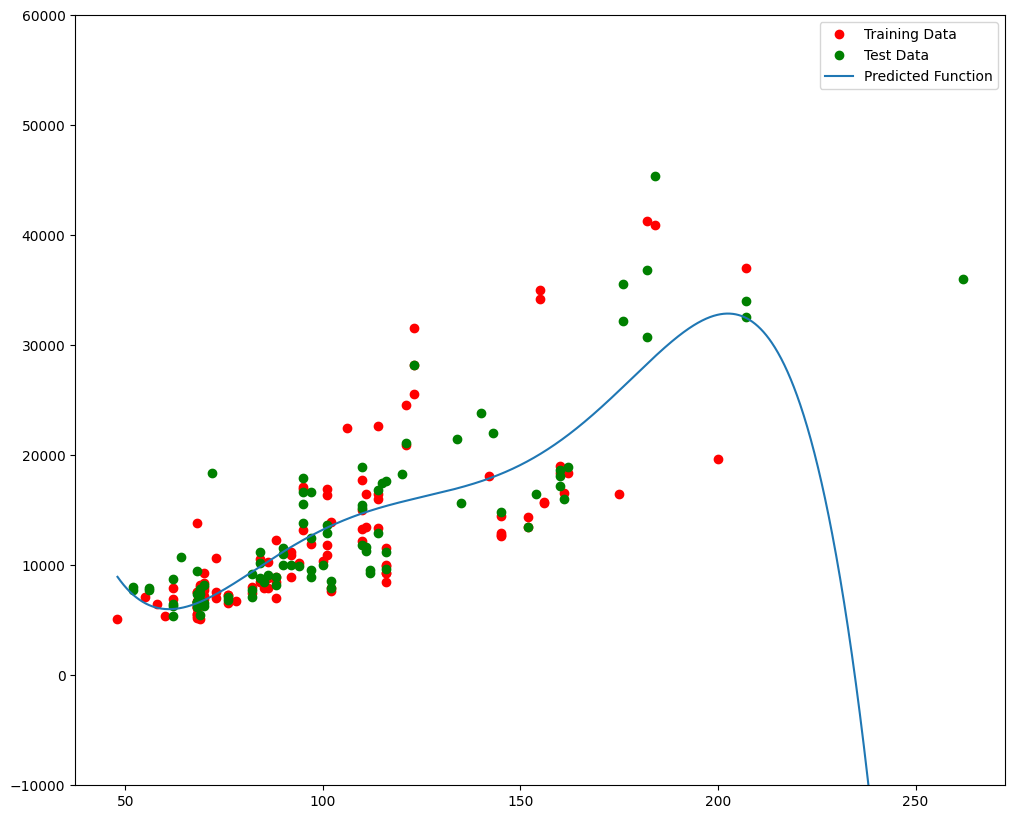

In [41]:
PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train, y_test, poly, pr)

Рисунок 3: Модель полиномиальной регрессии, в которой красные точки представляют собой обучающие данные, зеленые точки представляют данные тестирования, а синяя линия представляет прогноз модели. 


Мы видим, что оценочная функция, по -видимому, отслеживает данные, но около 200 лошадиных сил, функция начинает расходиться с точками данных данных.

 R^2 для тренировочныхз данных объекта полиномиальной регрессии poly:

 * Объект poly, созданный с использованием класса LinearRegression, представляет собой модель линейной регрессии, которая была обучена на преобразованных полиномиальных признаках. Такая модель называется полиномиальной регрессией.


In [42]:
poly.score(x_train_pr, y_train)

0.6007386015798579

Метод используется для вычисления R-квадрат оценки полиномиальной регрессионной модели `poly` на преобразованных обучающих данных `x_train_pr` и исходных целевых данных `y_train`.

Метод `score` в моделях линейной регрессии scikit-learn, включая полиномиальную регрессию, вычисляет показатель R-квадрат. Показатель R-квадрат - это статистический показатель, отражающий долю дисперсии зависимой переменной (y), которая может быть объяснена независимыми переменными (x) в модели. Она показывает, насколько хорошо модель соответствует данным.

В приведенном фрагменте кода `x_train_pr` - это преобразованные обучающие данные, полученные с помощью метода `fit_transform` объекта полиномиального преобразования, а `y_train` - исходные целевые данные. Метод `score` принимает эти два массива в качестве входных данных и возвращает значение R-квадрат.

Вызвав метод `poly.score(x_train_pr, y_train)`, можно оценить эффективность модели полиномиальной регрессии на обучающих данных. Оценка варьируется от 0 до 1, где 1 означает идеальное соответствие, а 0 - то, что модель не объясняет ни одной дисперсии целевой переменной.

R^2 данных тестирования:


In [43]:
poly.score(x_test_pr, y_test)

-4.540925110270035

Мы видим, что R^2 для данных обучения составляет 0,60, в то время как r^2 

на тестовых данных составляло -4,54.Чем ниже r^2, тем хуже модель.

**Отрицательный r^2 является признаком для переживания.**


Давайте посмотрим, как изменяется R^2 на тестовых данных для полиномов различных порядков, а затем построим результаты для выбора оптимального порядка полинома:



Text(3, 0.75, 'Maximum R^2 ')

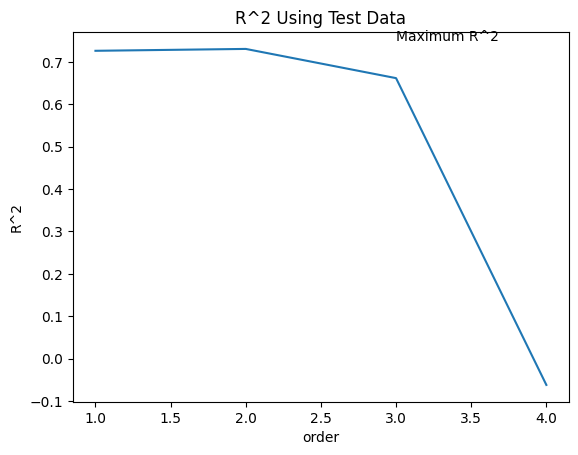

In [44]:
# В этой строке создается пустой список Rsqu_test, в который будут добавляться значения R-квадрат для каждой степени полинома.
Rsqu_test = []
# Здесь определяется список order, который содержит значения степеней полинома, которые мы хотим проверить.
order = [1, 2, 3, 4]
# Это начало цикла for, который будет выполняться для каждого значения n из списка order.
for n in order:
    # В этой строке создается объект pr класса PolynomialFeatures с заданной степенью полинома n. 
    # Этот объект будет использоваться для преобразования признаков в полиномиальные признаки.
    pr = PolynomialFeatures(degree=n)
    # Здесь применяется метод fit_transform объекта pr к тренировочным данным x_train[['horsepower']]. Этот метод выполняет преобразование признаков в полиномиальные признаки заданной степени n и сохраняет результат в переменной x_train_pr.
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    # Аналогично предыдущей строке, здесь применяется метод fit_transform объекта pr к тестовым данным x_test[['horsepower']] для преобразования признаков в полиномиальные признаки заданной степени n и сохранения результата в переменной x_test_pr.
    x_test_pr = pr.fit_transform(x_test[['horsepower']])    
    # Эта строка обучает модель линейной регрессии lr на преобразованных тренировочных данных x_train_pr и целевых значениях y_train.
    lr.fit(x_train_pr, y_train)
    # Здесь вычисляется R-квадрат для модели lr на преобразованных тестовых данных x_test_pr и целевых значениях y_test, и это значение добавляется в список Rsqu_test.
    Rsqu_test.append(lr.score(x_test_pr, y_test))
# Эти строки используют библиотеку matplotlib для создания графика. Они строят график R-квадрат в зависимости от степени полинома order. Затем добавляются подписи осей и заголовок графика. В последней строке добавляется текстовая аннотация на графике.
plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(3, 0.75, 'Maximum R^2 ')    

Мы видим, что R^2 постепенно увеличивается до тех пор, пока не будет использован заказ 2.5 полинома.

Затем R^2 резко уменьшается после достижения степени полинома 3, это значит, что оптимальной для полиномиального преобразования будет степень 2, так как при этой степени r^2 максимальный (близок к 1).


Для поиска оптимального разделения данных мы будем использовать слудующую функцию:

In [45]:
# функция my_polynomial_regression будет принимать порядок полинома и процент разделения
def my_polynomial_regression(order, test_data_percent):
    # Разделение данных на обучающую и тестовую выборки, 
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_data_percent, random_state=0)
    
    # Создание объекта PolynomialFeatures для выполнения полиномиального преобразования или полиномиальных признаков. order указывает степень полинома.
    pr = PolynomialFeatures(degree=order)
    
    # Применение полиномиального преобразования к обучающим данным.Создает матрицу с полиномиальными признаками для обучающего набора.
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    
    # Применение полиномиального преобразования к тестовым данным. Создает матрицу с полиномиальными признаками для тестового набора.
    # x_test_pr = pr.fit_transform(x_test[['horsepower']])
    
    # Создание объекта LinearRegression для выполнения линейной регрессии
    poly = LinearRegression()
    
    # Обучение модели линейной регрессии на преобразованных обучающих данных
    poly.fit(x_train_pr, y_train)
    
    # Построение графика с использованием функции PollyPlot
    PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train, y_test, poly, pr)

Следующий интерфейс позволяет экспериментировать с различными полиномиальными порядками и различными количествами данных.


In [ ]:
help(interact)

Можно использовать функцию interact из библиотеки ipywidgets для создания интерактивного элемента управления, позволяющего изменять значения параметров order (степень полинома) и test_data_percent (процент тестовых данных) и визуализировать результаты анализа.
Эти данные передаются в виде кортежей

In [47]:
# (0, 6, 1)- от 0 до 6 шаг 1
# (0.05, 0.95, 0.05) от 5 процентов до 95 процентов с шагом 5 процентов
interact(my_polynomial_regression, order=(0, 6, 1), test_data_percent=(0.05, 0.95, 0.05))

interactive(children=(IntSlider(value=3, description='order', max=6), FloatSlider(value=0.45, description='tes…

<function __main__.my_polynomial_regression(order, test_data_percent)>

Если интерактивно поигать с параметрами модели, то линия лучше объясняет цену если использовать порядок полинома 2 и 80 процентов тестовых данных


<b> мы можем выполнить полиномиальные преобразования с мультипараметрами, а точнее с несколькими признаками. Создать объект полиномиального преобразования  PR1 второй степени, так как мы выяснили, что эта степень оптимальна. </B>
</div>

In [48]:
pr1=PolynomialFeatures(degree=2) 



<b>
 Преобразовать образцы обучения и тестирования для функций «Мощность», «бордюр», «Размер двигателя» и «расход топлива Шоссе».Подсказка: используйте метод "fit_transform". </B>
</div>


In [49]:
x_train_pr1=pr1.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']])
x_test_pr1=pr1.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']])


До полиномиального преобразования хранится 4 признака и 109 наблюдений

In [50]:
x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']].shape

(109, 4)

In [51]:
x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']]

,horsepower,curb-weight,engine-size,highway-L/100km
10,101,2395,108,8.103448
186,68,2579,97,6.184211
73,68,1918,92,5.731707
191,114,3042,141,8.392857
177,85,2209,109,6.911765
...,...,...,...,...
67,123,3770,183,9.400000
192,162,3045,130,10.681818
117,68,1967,90,6.184211
47,68,1890,91,7.580645


Сколько признаков хранится в новом объекте после полиномиального преобразования?



In [52]:
print("Размер матрицы после преобразования: ", x_train_pr1.shape,"\n")

print('ПРЕОБРАЗОВАННАЯ МАТРИЦА: \n', x_train_pr1)

Размер матрицы после преобразования:  (109, 15) 

ПРЕОБРАЗОВАННАЯ МАТРИЦА: 
 [[1.00000000e+00 1.01000000e+02 2.39500000e+03 ... 1.16640000e+04
  8.75172414e+02 6.56658740e+01]
 [1.00000000e+00 6.80000000e+01 2.57900000e+03 ... 9.40900000e+03
  5.99868421e+02 3.82444598e+01]
 [1.00000000e+00 6.80000000e+01 1.91800000e+03 ... 8.46400000e+03
  5.27317073e+02 3.28524688e+01]
 ...
 [1.00000000e+00 6.80000000e+01 1.96700000e+03 ... 8.10000000e+03
  5.56578947e+02 3.82444598e+01]
 [1.00000000e+00 6.80000000e+01 1.89000000e+03 ... 8.28100000e+03
  6.89838710e+02 5.74661811e+01]
 [1.00000000e+00 1.61000000e+02 2.97600000e+03 ... 2.92410000e+04
  1.67437500e+03 9.58767361e+01]]


Результат (109, 15) означает, что после полиномиального преобразования с использованием PolynomialFeatures с параметром degree=2, оригинальный набор признаков (`horsepower, curb-weight, engine-size, highway-L/100km`) был преобразован в новый набор признаков, состоящий из 15 столбцов. 

`PolynomialFeatures` выполняет генерацию полиномиальных признаков путем возведения исходных признаков в заданную степень (в данном случае, до второй степени) и комбинирования их между собой. Это позволяет учесть нелинейные зависимости между признаками.

Таким образом, исходное пространство признаков **(horsepower, curb-weight, engine-size, highway-L/100km)**, ***состоящее из 4 столбцов***, было расширено до нового пространства признаков.


Полиномиальное преобразование применяется для создания новых признаков путем комбинирования и возведения в степень существующих признаков данных. 
В данном случае, формула полиномиального преобразования для создания новых признаков может быть записана следующим образом:

`x_train_pr1 = [1, horsepower, curb-weight, engine-size, highway-L/100km, horsepower^2, horsepower*curb-weight, horsepower*engine-size, horsepower*highway-L/100km, (curb-weight)^2, curb-weight*engine-size, curb-weight*highway-L/100km, (engine-size)^2, engine-size*highway-L/100km, (highway-L/100km)^2]`

Где:
- `1` - константа,
- `horsepower, curb-weight, engine-size, highway-L/100km` - существующие признаки,
- `horsepower^2` - квадрат значения признака horsepower,
- `horsepower*curb-weight, horsepower*engine-size, horsepower*highway-L/100km` - произведение значения признака `horsepower` на значения других признаков,
- `(curb-weight)^2` - квадрат значения признака `curb-weight`,
- `curb-weight*engine-size, curb-weight*highway-L/100km` - произведение значения признака `curb-weight` на значения других признаков,
- `(engine-size)^2` - квадрат значения признака `engine-size`,
- `engine-size*highway-L/100km` - произведение значения признака `engine-size` на значение признака `highway-L/100km`,
- `(highway-L/100km)^2` - квадрат значения признака `highway-L/100km.`

Таким образом, после полиномиального преобразования исходных четырех признаков мы получаем новую матрицу `x_train_pr1` размером (`109, 15`), где каждый столбец представляет собой новый признак, созданный путем комбинации и возведения в степень исходных признаков данных.


## Создадим модель линейной регрессии «Poly1».
Сразу Обучим объект, используя метод «Fit», используя полиномиальные функции. </B>
</div>


In [53]:
poly1=LinearRegression().fit(x_train_pr1,y_train)


В этом коде выполняются следующие действия:

1. Создание экземпляра класса LinearRegression(): `poly1 = LinearRegression()`. Класс LinearRegression() представляет линейную регрессию, которая используется **для предсказания зависимой переменной на основе одной или нескольких независимых переменных**.

2. Вычисление параметров модели: `poly1.fit(x_train_pr1, y_train)`. Метод fit() используется для обучения модели на обучающих данных. ***В данном случае, x_train_pr1 представляет собой матрицу признаков после полиномиального преобразования, а y_train - вектор целевой переменной.***

3. Обучение модели: При вызове метода `fit` модель **аппроксимирует данные** (***ищет наилучшую модель, которая наиболее точно предсказывает зависимую переменную на основе доступных признаков***), находит оптимальные коэффициенты и интерсепт (если присутствует), чтобы минимизировать сумму квадратов ошибок между предсказанными значениями и фактическими значениями зависимой переменной.

Таким образом, в результате выполнения этого кода объект `poly1` будет представлять обученную модель линейной регрессии, которая может использоваться для предсказания значений зависимой переменной на новых данных, основываясь на новых признаках, созданных полиномиальным преобразованием.


<b> Используйте метод `predict` для прогнозирования вывода на полиномиальных признаках, а затем используйте функцию «Distribution Plot» для отображения распределения прогнозируемого тестового выхода в зависимости от фактических тестовых данных. </b>
</div>


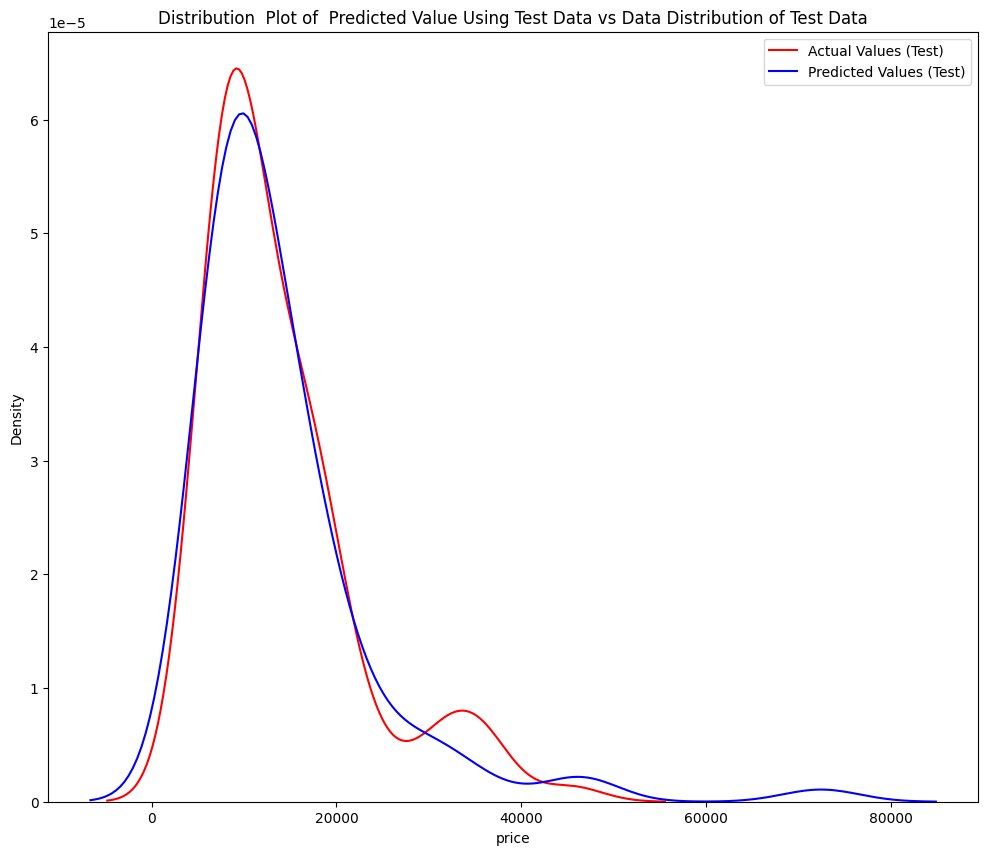

In [54]:
yhat_test1=poly1.predict(x_test_pr1)

Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'

DistributionPlot(y_test, yhat_test1, "Actual Values (Test)", "Predicted Values (Test)", Title)


<b> Используя график распределения выше, опишите (в словах) две области, где прогнозируемые цены менее точны, чем фактические цены. </b>

Прогнозируемая стоимость выше фактической для автомобилей в ценовом диапазоне $10 000, и наоборот, прогнозируемая цена ниже стоимости в диапазоне $30 000 - $40 000. Таким образом, в этих диапазонах модель не столь точна.
</div>

<h2 id="ref3">Часть 3: Ridge Regression. Гребнивая регрессия</h2> 


В этом разделе мы рассмотрим регрессию гребня и посмотрим, как параметр альфа меняет модель. 

Здесь наши тестовые данные будут использоваться в качестве данных проверки.


Давайте выполним степень два полиномиальных преобразования наших данных.


In [55]:
# создание объекта PolynomialFeatures с параметром degree=2, что значит, что будет выполняться полиномиальное преобразование признаков с степенью 2. 
# Это означает, что для каждого признака будет созданы новые признаки, включающие все возможные комбинации суммы и произведения признаков с указанной степенью.
pr=PolynomialFeatures(degree=2)
# Затем происходит применение полиномиального преобразования к данным обучающего и тестового наборов. В качестве входных данных используются указанные признаки из x_train и x_test.
x_train_pr=pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km','normalized-losses','symboling']])
x_test_pr=pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km','normalized-losses','symboling']])
# Как результат, переменные x_train_pr и x_test_pr содержат матрицы, где каждый столбец представляет различные комбинации признаков с указанной степенью

Давайте импортируем <b> ridge </b> из модуля <b> линейных моделей </b>.


In [56]:
from sklearn.linear_model import Ridge

In [ ]:
# ознакомимся с функцией
help(Ridge)
# Ridge(alpha=1.0, *, fit_intercept=True, copy_X=True, max_iter=None, tol=0.0001, solver='auto', positive=False, random_state=None) -> параметры которые принимает функция


- `alpha` - это параметр регуляризации, который контролирует силу штрафа за сложность модели. Большее значение alpha означает более сильную регуляризацию, что помогает предотвратить переобучение модели.

- `fit_intercept` - когда этот параметр имеет значение True, модель будет подстраивать величину свободного члена (intercept) в уравнении линейной регрессии. Если вы хотите, чтобы ваша модель проходила через начало координат, то можно установить значение False.

- `copy_X` - это параметр, указывающий, следует ли создавать копию массива признаков X. Если установлено значение True, то будет создана копия X, иначе будет использоваться сам X.

- `max_iter` - это количество итераций, которое будет выполнено во время оптимизации модели. Если не указано значение, то алгоритм будет продолжать работать, пока не достигнет заданной точности или пока не будет выполнено максимальное количество итераций.

- `tol` - это параметр, который описывает точность, с которой модель должна соответствовать целевым значениям. Если изменение весов модели меньше, чем tol, то алгоритм считается сошедшимся.

- `solver` - это метод, используемый для решения оптимизационной задачи модели Ridge. Значение 'auto' позволяет автоматически выбирать наиболее подходящий метод в зависимости от типа данных.

- `positive` - когда этот параметр имеет значение True, модель ограничивает веса и свободный член только положительными значениями. Это может быть полезно в некоторых случаях, например, при предсказании неотрицательных величин.

- `random_state` - это параметр, который управляет генерацией случайных чисел во время обучения модели. Если задано конкретное значение, то результаты будут воспроизводимыми.


## **solver** : {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'

`solver` отвечает за выбор алгоритма оптимизации при обучении модели. Вот объяснение каждого возможного значения параметра `solver`:

1. `auto`: Алгоритм выбирается автоматически на основе данных и задачи. Обычно используется алгоритм 'lsqr' для плотных матриц данных и алгоритм 'sparse_cg' для разреженных матриц данных.

2. `svd`: Выполняется сингулярное разложение матрицы признаков для нахождения оптимальных весов модели. Этот метод эффективен для данных со средним количеством признаков.

3. `cholesky`: Применяется разложение Холецкого матрицы признаков для нахождения оптимальных весов модели. Этот метод эффективен для данных с небольшим количеством признаков и высоким значением матрицы.

4. `lsqr`: Используется итеративный метод наименьших квадратов для нахождения оптимальных весов модели. Этот метод подходит для больших и плотных матриц данных.

5. `sparse_cg`: Используется итеративный метод сопряженных градиентов для нахождения оптимальных весов модели. Этот метод подходит для больших и разреженных матриц данных.

6. `sag` (Stochastic Average Gradient): Применяется стохастический метод среднего градиента для нахождения оптимальных весов модели. Этот метод эффективен для больших наборов данных.

7. `saga`: Расширение метода 'sag', которое также поддерживает регуляризацию L1. Этот метод эффективен для больших наборов данных и задач с L1-регуляризацией.

8. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno): Используется алгоритм оптимизации L-BFGS для нахождения оптимальных весов модели. Этот метод хорошо подходит для небольших наборов данных.

Выбор конкретного значения `solver` зависит от размера данных, плотности/разреженности матрицы признаков и требуемой скорости обучения модели. Обычно параметр `solver` можно оставить равным 'auto'

Давайте создадим объект регрессии гребня, установив параметр регуляризации (альфа) на 0,1


In [58]:
RigeModel=Ridge(alpha=0.1)

Как и обычная регрессия, вы можете обучать ее, используя метод <b> fit </b>.


In [59]:
# обучим модель передавая тренировочные преобразованные полиномиальные признаки и фактические цены из тренировочного набора данных
RigeModel.fit(x_train_pr, y_train)

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.01268e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=0.1)

Точно так же вы можете получить прогноз: 


In [60]:
# положим в переменную yhat результат функции predict применяемой к объекту гребниевой регрессии, и передавая  тестовые преобразованные данные
yhat = RigeModel.predict(x_test_pr)

Давайте сравним первые пять прогнозируемых образцов с нашим тестовым набором содержащих фактические цены:


In [61]:
print('predicted:', yhat[0:4])
print('test set :', y_test[0:4].values)

predicted: [ 6734.61566672  8508.05218165 15871.35195549  6822.20329719]
test set : [ 6295.  9988. 12440.  7799.]


Мы выбираем значение альфа, которое минимизирует ошибку теста.
Для этого мы можем использовать для циклы.
Мы также создали планку прогресса, чтобы увидеть, сколько итераций мы завершили до сих пор.

Слудующий код выполняет цикл по разным значениям параметра `alpha` и для каждого значения обучает модель Ridge. Затем он вычисляет коэффициент детерминации (R^2) на тестовом и тренировочном наборах данных, сохраняет их значения в соответствующие списки (`Rsqu_test` и `Rsqu_train`) и выводит прогресс выполнения с использованием библиотеки tqdm.


In [62]:
# Импорт библиотеки для отображения прогресса выполнения цикла
from tqdm import tqdm 
# Список для хранения значений коэффициента детерминации (R^2) на тестовом наборе данных
Rsqu_test = [] 
# Список для хранения значений коэффициента детерминации (R^2) на тренировочном наборе данных
Rsqu_train = []  
# Список-заглушка
dummy1 = []  
# Массив значений alpha, увеличивающихся с шагом 10 от 0 до 9990
Alpha = 10 * np.array(range(0, 1000))
# Создание объекта прогресс-бара с указанием списка Alpha 
pbar = tqdm(Alpha)  

# Цикл по значениям alpha из списка Alpha
for alpha in pbar:  
    RigeModel = Ridge(alpha=alpha)  # Создание объекта модели Ridge с заданным значением alpha
    RigeModel.fit(x_train_pr, y_train)  # Обучение модели на тренировочных данных
    
    # Вычисление коэффициента детерминации (R^2) на тестовом и тренировочном наборах данных
    test_score, train_score = RigeModel.score(x_test_pr, y_test), RigeModel.score(x_train_pr, y_train)
    
    # Обновление информации в прогресс-баре
    pbar.set_postfix({"Test Score": test_score, "Train Score": train_score})

    Rsqu_test.append(test_score)  # Добавление значения R^2 на тестовом наборе данных в список Rsqu_test
    Rsqu_train.append(train_score)  # Добавление значения R^2 на тренировочном наборе данных в список Rsqu_train


  0%|          | 0/1000 [00:00<?, ?it/s, Test Score=0.52, Train Score=0.879] 

100%|██████████| 1000/1000 [00:02<00:00, 422.70it/s, Test Score=0.514, Train Score=0.867]


- `1000/1000` указывает на то, что все 1000 итераций цикла `for` были выполнены.
- `[00:03<00:00, 329.16it/s]` говорит о времени, затраченном на выполнение цикла. В данном случае, время выполнения составляет 3 секунды.
- `Test Score=0.514, Train Score=0.867` представляет значения коэффициента детерминации (R^2) на тестовом (`Test Score`) и тренировочном (`Train Score`) наборах данных для последней итерации цикла.

Исходя из этих результатов, можно сделать следующие выводы:
- Значение R^2 на тестовом наборе данных составляет `0.514`, что говорит о том, что модель объясняет примерно `51.4%` дисперсии в данных которые она не видела ранее.
- Значение R^2 на тренировочном наборе данных составляет `0.867`, что указывает на то, что модель хорошо предсказывает зависимую переменную на тренировочных данных и объясняет около `86.7% дисперсии `в данных.

В целом, чем ближе значение R^2 к 1, тем лучше модель соответствует данным, поэтому ваша модель дает относительно хорошие результаты на тренировочных данных и вполне приемлемые результаты на тестовых данных.

Мы можем построить значение r^2 для разных альфа:
Слудующий код создает график зависимости значений коэффициента детерминации (R^2) от значения параметра `alpha`. 

- `plt.figure(figsize=(width, height))` создает фигуру (область для рисования) с указанной шириной и высотой.

- `plt.plot(Alpha, Rsqu_test, label='validation data')` рисует линию графика для значений R^2 на тестовом наборе данных (`Rsqu_test`) в зависимости от значений `alpha`. Метка "validation data" будет отображаться в легенде графика.

- `plt.plot(Alpha, Rsqu_train, 'r', label='training Data')` рисует линию графика для значений R^2 на тренировочном наборе данных (`Rsqu_train`) в зависимости от значений `alpha`. Красный ('r') цвет указывает на то, что линия будет отображаться красным цветом. Метка "training Data" будет отображаться в легенде графика.

- `plt.xlabel('alpha')` устанавливает подпись оси x на графике.

- `plt.ylabel('R^2')` устанавливает подпись оси y на графике.

- `plt.legend()` добавляет легенду к графику, чтобы показать, какие линии соответствуют каким данным.


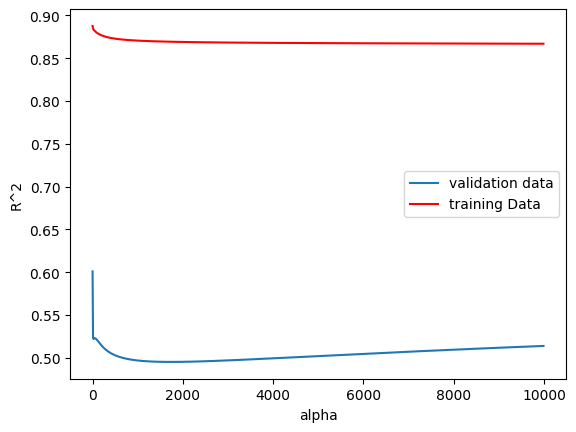

In [63]:
# Нанесение графика значений R^2 на тестовом наборе данных
plt.plot(Alpha, Rsqu_test, label='validation data')

# Нанесение графика значений R^2 на тренировочном наборе данных, красным цветом
plt.plot(Alpha, Rsqu_train, 'r', label='training Data')

plt.xlabel('alpha')  # Установка подписи оси x
plt.ylabel('R^2')  # Установка подписи оси y
plt.legend()  # Добавление легенды к графику

** Рисунок 4 **: Синяя линия представляет r^2 данных тестирования, а красная линия представляет r^2 учебных данных.
Ось X представляет различные значения альфа.


Здесь модель создана и протестирована на одних и тех же данных, поэтому данные обучения и тестирования одинаковы.

Красная линия на рисунке 4 представляет r^2 учебных данных.

По мере увеличения альфа, R^2 уменьшается. ***Следовательно, по мере увеличения альфа модель обученная на учебных данных ухутшается***

Синяя линия представляет r^2 в данных проверки. По мере увеличения значения для альфа R^2 увеличивается 

<h2 id="ref4">Часть 4: Grid Search</h2>


Термин Альфа - это гиперпараметр.
У Sklearn есть класс <b> gridsearchcv </b>, чтобы упростить процесс поиска лучшего гиперпараметра.


Давайте импортируем <b> gridsearchcv </b> из модуля <b> model_selection </b>.


In [64]:
from sklearn.model_selection import GridSearchCV

Мы создаем словарь значений параметров:


In [65]:
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
parameters1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

Создайте объект регрессии гребня


In [66]:
RR=Ridge()
RR

Ridge()

Создайте объект поиска :


In [67]:
# в объект передадим результат, возвращаемый функцией, применяемой к объекту гребниевой регрессии RR, с параметрами ALPHA которые в положили в список, разделим данные на 4 фолда
Grid1 = GridSearchCV(RR, parameters1, cv=4)

Обучите модель:

In [68]:
Grid1.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']], y_data)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000,
                                    100000]}])

Объект, возвращаемый методом GridSearchCV из библиотеки scikit-learn, обычно используется для поиска оптимальных параметров модели. Он не предоставляет возможности для сделать прогнозы на новых данных.

Однако, после того как были найдены оптимальные параметры, вы можете создать новый экземпляр модели с этими параметрами и использовать его для делания прогнозов на новых данных. 

<code>

***Создание экземпляра модели с оптимальными параметрами***

BestRR = GridSearchCV.best_estimator_

***Обучение модели на всех данных***

BestRR.fit(X_train, y_train)

***Прогноз на новых данных***

predictions = BestRR.predict(X_test)
</code>

Таким образом, получив оптимальные параметры для модели с помощью GridSearchCV, вы можете использовать их для экземпляра модели и делания прогнозов.
Мы можем получить оценку с лучшими параметрами и назначить его переменной BestRR следующим образом:


In [102]:
# Создание экземпляра модели с оптимальными параметрами
BestRR=Grid1.best_estimator_
BestRR

Ridge(alpha=10000)

In [103]:
# Обучение модели на всех данных
BestRR.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']], y_train)



Ridge(alpha=10000)

Теперь мы проверяем нашу модель на тестовых данных чтобы понять, как соответствует модель тем данным, которые она не видела ранее (не обучалась на них):


In [104]:
BestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size','highway-L/100km']], y_test)

0.8270997056594994

Если лучший результат (`0.82`) был получен с использованием модели Ridge Regression (RR), то это означает, что лучшая регрессионная модель для предсказания целевой переменной будет RR с настройками параметров, указанными в GridSearchCV. 

Данные параметры позволяют достичь наилучшей производительности модели на данном наборе данных.

Теперь, чтобы использовать эту модель для предсказания, вам необходимо применить метод `predict` к новым данным. В вашем случае, для предсказания целевой переменной (`y`) на основе признаков (`x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']]`), вы можете использовать следующий код:


`predictions = Grid1.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']])`


Здесь `predictions` будет содержать предсказанные значения для `y` на основе ваших тестовых данных. Вы можете использовать эти предсказания для дальнейшего анализа или оценки точности модели.

In [105]:
predictions = BestRR.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']])

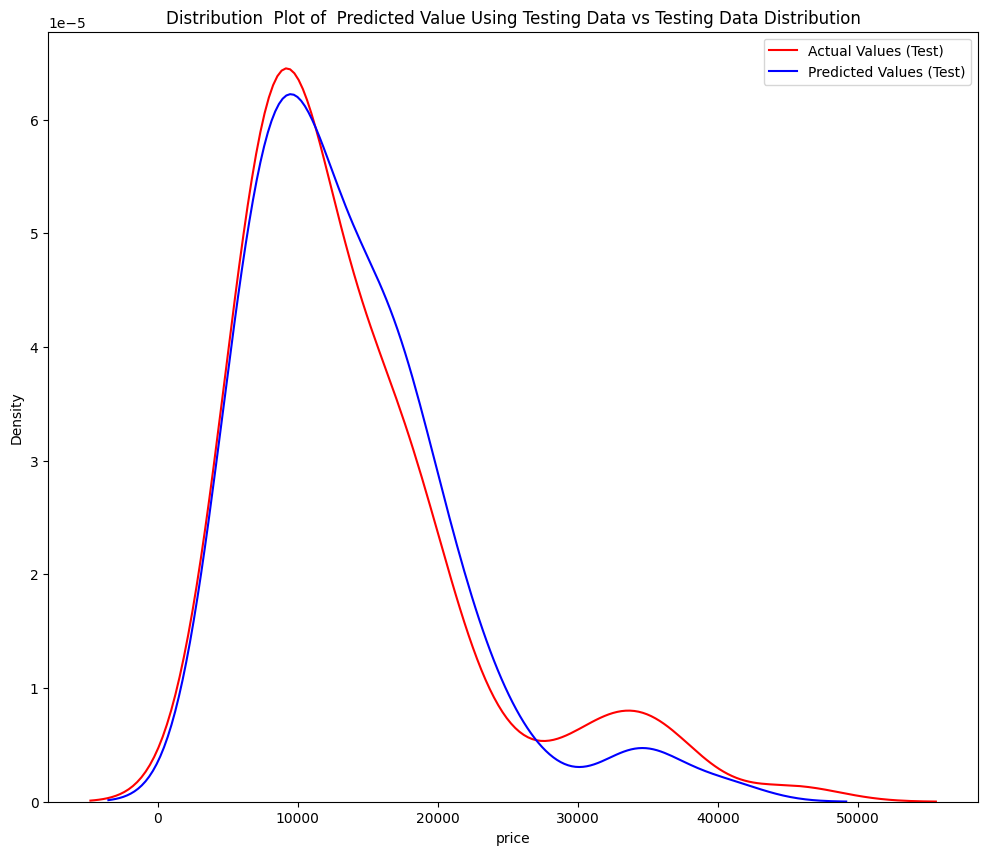

In [99]:
# наша функция принимает наименование таблицы с переменной Title. положим туда наш заголовок
Title = 'Distribution  Plot of  Predicted Value Using Testing Data vs Testing Data Distribution'
# применим функцию графика распределения
DistributionPlot(y_test, predictions, "Actual Values (Test)", "Predicted Values (Test)", Title)

In [100]:
# напомним себе какие параметры могут принимать признаки
df.head(5)

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,price,city-L/100km,highway-L/100km,fuel-type-diesel,fuel-type-gas,aspiration-std,aspiration-turbo
0,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,2.68,9.0,111,5000.0,13495.0,11.190476,8.703704,0,1,1,0
1,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,2.68,9.0,111,5000.0,16500.0,11.190476,8.703704,0,1,1,0
2,1,122,94.5,0.822681,0.909722,0.876254,2823,152,2.68,3.47,9.0,154,5000.0,16500.0,12.368421,9.038462,0,1,1,0
3,2,164,99.8,0.848630,0.919444,0.908027,2337,109,3.19,3.40,10.0,102,5500.0,13950.0,9.791667,7.833333,0,1,1,0
4,2,164,99.4,0.848630,0.922222,0.908027,2824,136,3.19,3.40,8.0,115,5500.0,17450.0,13.055556,10.681818,0,1,1,0


Чтобы получить предсказание для фактических данных, вам необходимо создать массив или список значений признаков и передать их в метод `predict` модели. 
чтобы предсказать целевую переменную для данных со значениями `'horsepower' = 100`, `'curb-weight' = 2500`, `'engine-size' = 109` и `'highway-L/100km' = 9`, вы можете использовать следующий код:

In [101]:
features_for_prediction = [[111, 2548, 130, 8.70]]
prediction_fact = BestRR.predict(features_for_prediction)
prediction_fact

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


array([13440.56923593])

# Робастная регрессия

Робастная регрессия - это статистический метод, который используется для анализа данных с выбросами или наличием несоблюдений предпосылок классической регрессии. Ее основная цель состоит вении модели, которая была бы менее чувствительной к выбросам или нарушениям предпосылок. Вот основные шаги реализации робастной регрессии:

1. Загрузка данных:те необходимые библиотеки и загрузите данные, с которыми вы будете работать.

2. Предварительная обработка данных: Пров не предварительнуюку данных, такую как удаление пропущенных значений, нормализация или стандартизация переменных и т. д.

3. Построение модели: Выберите тип робастной регрессии, который лучше всего подход вашей задачи. Некоторые из наиболее популярных методов включают Huber Loss, RANSAC, Theil–Sen и M-оценивание. В зависимости от выбранного метода, настройте соответствующие параметры модели.

4. Обучение модели: Используйте данные для обучения выбранной модели робастной регрессии. В процессе обучения модель будет находить оптимальныеффициенты, которые наилучшим образом объясняют зависимость между входными и целевыми переменными.

5. Оценка: Оцените качество модели, используя соответствующие метрики, например, коэффициент детерминации (R-squared), среднеквадратическую ошибку (MSE) или среднюю абсолютную ошибку (MAE). Сравните результаты с другими моделями регрессии или базовыми моделями.

6. Валидация модели: Проверьте качество модели, используя отложенную выборку или кросс-валидацию. Это поможет оценить, насколько модель будет работать на новых данных и избежать переобучения. Интерпретация результатов: Проанализируйте важность факторов и дополнительные выводы, чтобы лучше понять связь между входными и целевыми переменными. Используйте соответствующие методы, такие как анализ коэффициентов или визуализацию, чтобы лучше понять влияние каждогоа на целевую переменную.

Таким образом, робастная регрессия позволяет построить более устойчивую модель, которая способна работать с выбросами и нарушениями предпосылок классической регрессии. Это может быть особенно полезно в реальных ситуациях, где данные могут содержать неточности или аномалии.

In [148]:
import statsmodels.api as sm

X = x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']]
y = y_data

# введем константу
X = sm.add_constant(X)

# обучим модель
model = sm.OLS(y, X).fit()

# выведем
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     211.8
Date:                Wed, 12 Jul 2023   Prob (F-statistic):           1.32e-69
Time:                        15:14:35   Log-Likelihood:                -1902.6
No. Observations:                 199   AIC:                             3815.
Df Residuals:                     194   BIC:                             3832.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.429e+04   1403.354    -

Результаты OLS-регрессии показывают расчетные коэффициенты для независимых переменных в линейной регрессионной модели. Вот некоторые ключевые статистические данные и их интерпретация:

- R-квадрат: Это показатель доли дисперсии зависимой переменной (цены), которая может быть объяснена независимыми переменными. В данном случае значение R-квадрат равно 0,814, что указывает на то, что модель объясняет примерно 81,4% дисперсии цены.

- Скорректированный R-квадрат: В этом случае значение R-квадрат корректируется с учетом количества независимых переменных и объема выборки. Скорректированное значение R-квадрат составляет 0,810, что несколько ниже значения R-квадрат, но все равно обеспечивает хорошее соответствие модели.

- F-статистика: проверяет общую значимость модели, сравнивая дисперсию, объясненную регрессией, с остаточной дисперсией. Более высокое значение F-статистики указывает на более значимую связь между независимыми переменными и зависимой переменной. В данном случае F-статистика равна 211,8, а вероятность (p-значение) составляет 1,32e-69, что указывает на значимость модели.

- Коэффициенты: Коэффициенты представляют собой расчетное влияние каждой независимой переменной на зависимую переменную. Например, коэффициент для лошадиных сил равен 37,0552, что означает, что при увеличении мощности на единицу цена увеличивается на 37,0552 единицы при неизменности других переменных. Аналогично, коэффициенты для снаряженной массы и размера двигателя указывают на то, что эти переменные оказывают положительное влияние на цену.

- Р-значения: Значения p-values, связанные с каждым коэффициентом, проверяют нулевую гипотезу о том, что коэффициент равен нулю. Значение p-value меньше выбранного уровня значимости (например, 0,05) говорит о том, что коэффициент статистически значим. В данном случае все коэффициенты, за исключением показателя highway-L/100km, имеют p-значения ниже 0,05, что говорит об их статистической значимости.

В целом данная регрессионная модель объясняет значительную часть дисперсии цены, причем независимые переменные (мощность, снаряженная масса и размер двигателя) оказывают статистически значимое влияние на цену, в то время как влияние показателя шоссе-L/100 км не является статистически значимым на выбранном уровне значимости.

# Для предсказания цены на робастной регрессии можно использовать оцененные коэффициенты модели и значения независимых переменных для нового наблюдения. Вот шаги, которые можно следовать:

1. Получите оцененные коэффициенты модели робастной регрессии.

2. Соберите значения независимых переменных для нового наблюдения, для которого вы хотите сделать прогноз цены.

3. Умножьте каждое значение независимой переменной на соответствующий коэффициент модели.

4. Сложите результаты умножения, включая константу (если она присутствует в модели).

5. Полученная сумма будет предсказанным значением цены для нового наблюдения.

Обратите внимание, что робастная регрессия используется для более надежного оценивания модели в присутствии выбросов или гетероскедастичности в данных. Это улучшает статистические свойства оценок, но не изменяет основной процесс предсказания цены.

In [158]:
# Предположим, что у вас есть оцененные коэффициенты модели и значения независимых переменных
coefficients = np.array([-14290, 37.0552, 3.5031, 85.9503, 477.40])
# Создайте массив из значений независимых переменных для нового наблюдения
new_observation = np.array([1, 111, 2548, 130, 8.70])

# Вычислите предсказанное значение цены для нового наблюдения
predicted_price = np.dot(coefficients, new_observation)

print("Predicted Price:", predicted_price)

Predicted Price: 14075.944999999998


## Так или иначе, в данных присутсвовали и категориальные переменные, которые имели значительное влияние на цену, за счет этого могут быть значительные расхождения в предсказаниях

Посмотрим что из категориальных признаков может сильно влиять на цену. в предыдущем модуле мы это уже делали. Но посмотрм еще раз. Ведь это может быть и марка авто и тип привода и многое другое

In [161]:
df_full = pd.read_csv('C:/Users/admin/Desktop/python repo/DataAnalysis/analisys for prediction/Labs/clean_df.csv')
df_full.head()


,Unnamed: 0,symboling,normalized-losses,make,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,horsepower,peak-rpm,price,city-L/100km,highway-L/100km,horsepower-binned,fuel-type-diesel,fuel-type-gas,aspiration-std,aspiration-turbo
0,0,3,122,alfa-romero,two,convertible,rwd,front,88.6,0.811148,...,111,5000.0,13495.0,11.190476,8.703704,Low,0,1,1,0
1,1,3,122,alfa-romero,two,convertible,rwd,front,88.6,0.811148,...,111,5000.0,16500.0,11.190476,8.703704,Low,0,1,1,0
2,2,1,122,alfa-romero,two,hatchback,rwd,front,94.5,0.822681,...,154,5000.0,16500.0,12.368421,9.038462,Medium,0,1,1,0
3,3,2,164,audi,four,sedan,fwd,front,99.8,0.848630,...,102,5500.0,13950.0,9.791667,7.833333,Low,0,1,1,0
4,4,2,164,audi,four,sedan,4wd,front,99.4,0.848630,...,115,5500.0,17450.0,13.055556,10.681818,Low,0,1,1,0


In [181]:
df_categotical = df_full[['make','body-style','drive-wheels','engine-location','price']]
df_categotical.head(3)

,make,body-style,drive-wheels,engine-location,price
0,alfa-romero,convertible,rwd,front,13495.0
1,alfa-romero,convertible,rwd,front,16500.0
2,alfa-romero,hatchback,rwd,front,16500.0


<Axes: xlabel='body-style', ylabel='price'>

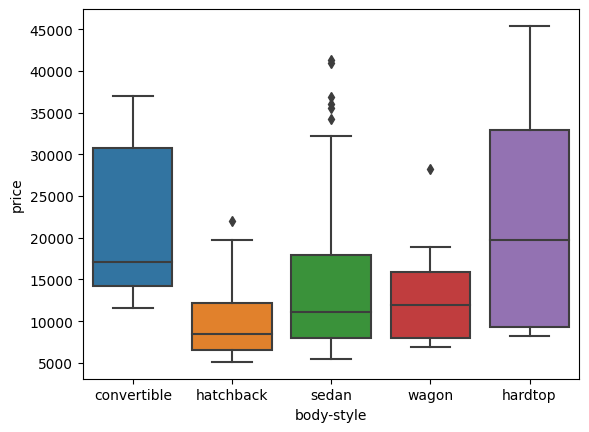

In [182]:
sns.boxplot(x="body-style", y="price", data=df_categorical)

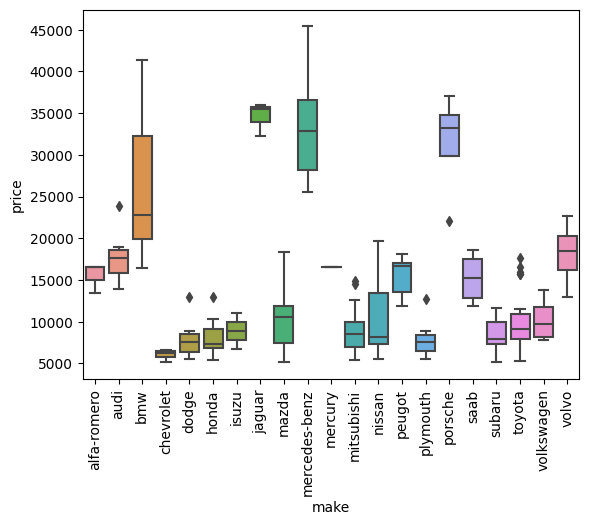

In [185]:
sns.boxplot(x="make", y="price", data=df_categorical)
# Поворачиваем лейблы по оси x на 90 градусов
plt.xticks(rotation=90)

# Отображаем график
plt.show()

В теории, это нормальная история, когда люди переплачивают за бренд, но есть вероятность, конечно, что апвтомобили некоторых марок просто имеют более высокие характеристики в среднем. 
### давайте посмотрим мерседес и мазду, чтобы сравнить параметры этих автомобилей

In [213]:
#  просмотрим какие автомобили в среднем стоят дорого
grouped_make = df_full[['make', 'price']].groupby(['make'], as_index=False).mean().sort_values('price', ascending=False)
grouped_make.head(10)

,make,price
7,jaguar,34600.000000
9,mercedes-benz,33647.000000
15,porsche,31400.500000
2,bmw,26118.750000
20,volvo,18063.181818
1,audi,17859.166667
10,mercury,16503.000000
0,alfa-romero,15498.333333
13,peugot,15489.090909
16,saab,15223.333333


In [217]:
# Нас бы устроило сравнение между не сильно редкими моделями авто, например мерседес
df_categorical[['make']].value_counts().to_frame().head(12)

,0
make,
toyota,32
nissan,18
mazda,17
honda,13
mitsubishi,13
volkswagen,12
subaru,12
volvo,11
peugot,11


In [220]:
df_mazda = df_full.loc[df_full['make'] == 'mazda']._get_numeric_data()
df_mazda.drop("Unnamed: 0", axis = 1, inplace=True)
# опишем самые значимые для цены параметры
describe1 = df_mazda[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']].describe()
describe1

,horsepower,curb-weight,engine-size,highway-L/100km
count,17.000000,17.000000,17.000000,17.000000
mean,85.529412,2297.823529,103.000000,7.660611
std,20.230292,269.747390,23.732889,1.647021
min,64.000000,1890.000000,70.000000,5.595238
25%,68.000000,1950.000000,91.000000,6.184211
50%,84.000000,2385.000000,91.000000,7.343750
75%,101.000000,2425.000000,122.000000,8.703704
max,135.000000,2700.000000,140.000000,10.217391


In [221]:
df_mercedes = df_full.loc[df_full['make'] == 'mercedes-benz']._get_numeric_data()
df_mercedes.drop("Unnamed: 0", axis = 1, inplace=True)
# опишем самые значимые для цены параметры
describe2= df_mercedes[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']].describe()
describe2

,horsepower,curb-weight,engine-size,highway-L/100km
count,8.000000,8.000000,8.000000,8.000000
mean,146.250000,3696.250000,226.500000,11.635764
std,27.164841,133.944285,53.891425,2.468440
min,123.000000,3495.000000,183.000000,9.400000
25%,123.000000,3642.500000,183.000000,9.400000
50%,139.000000,3727.500000,208.500000,11.227778
75%,162.250000,3755.000000,251.500000,13.463542
max,184.000000,3900.000000,308.000000,14.687500


In [223]:
# Сравнение среднего значения между двумя датами Вычтем из результатов описания мерседеса, так как он выше по цене результаты описания мазда
mean_difference =  describe2 - describe1
print("Разница в средних значениях:")
mean_difference

Разница в средних значениях:


,horsepower,curb-weight,engine-size,highway-L/100km
count,-9.000000,-9.000000,-9.000000,-9.000000
mean,60.720588,1398.426471,123.500000,3.975153
std,6.934549,-135.803105,30.158537,0.821418
min,59.000000,1605.000000,113.000000,3.804762
25%,55.000000,1692.500000,92.000000,3.215789
50%,55.000000,1342.500000,117.500000,3.884028
75%,61.250000,1330.000000,129.500000,4.759838
max,49.000000,1200.000000,168.000000,4.470109


***В целом, возможно разница в параметрах этих автомобилей может объясянть разницу в их ценах как минимум по большей части***

### Рассмотрим категории приводов

In [171]:
df_categorical[['drive-wheels']].value_counts()

drive-wheels
fwd             116
rwd              75
4wd               8
dtype: int64

В целом, у нас есть фактор который может влиять на цену

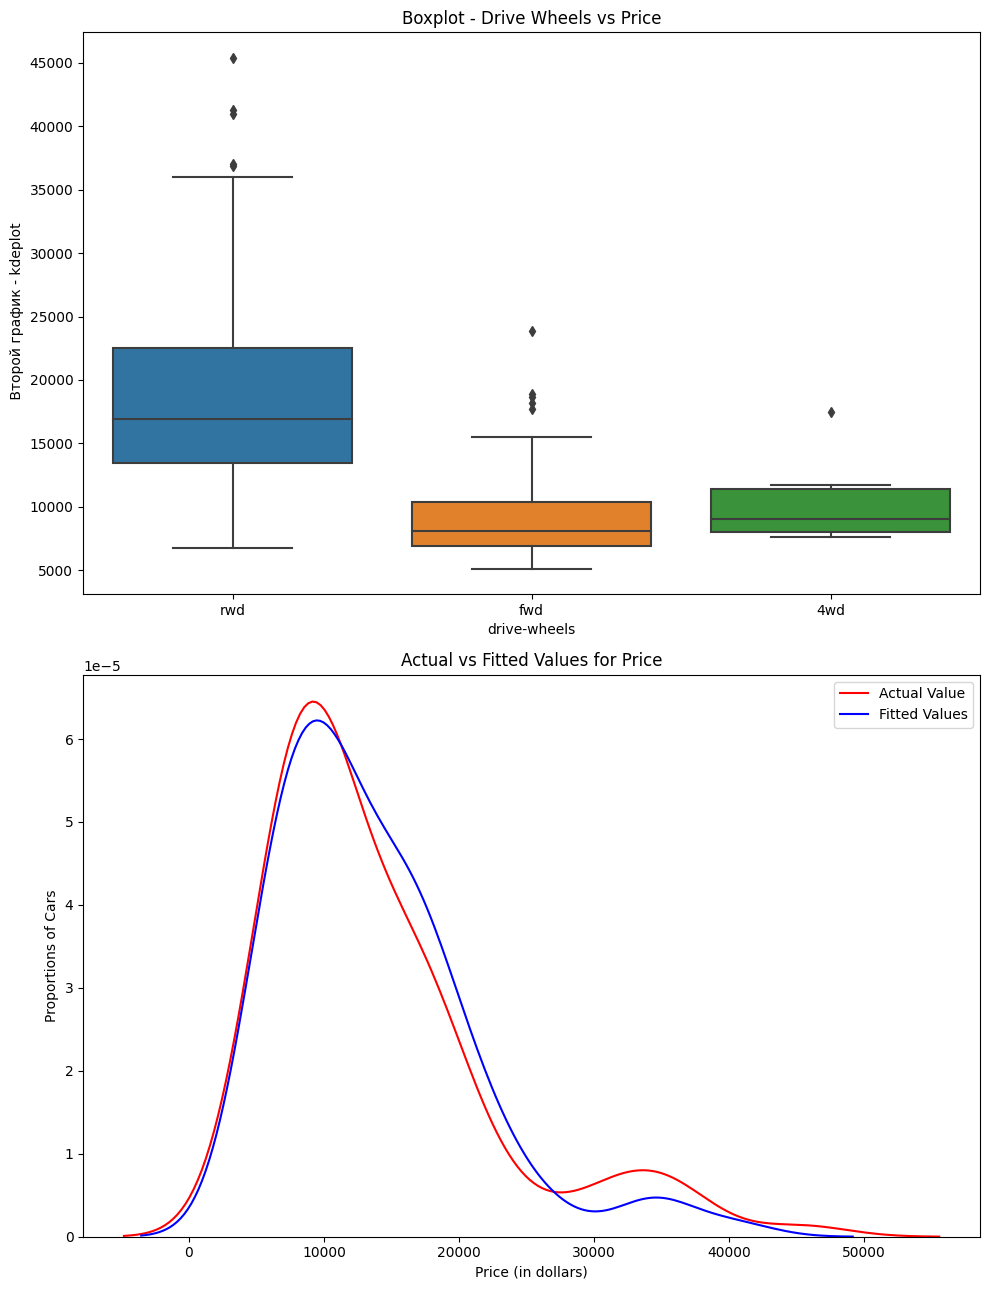

In [180]:
# Создание сетки для графиков
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 13))

# Первый график - boxplot
sns.boxplot(x="drive-wheels", y="price", data=df_categorical, ax=ax1)
ax1.set_title('Boxplot - Drive Wheels vs Price')

ax1.set_ylabel(' Второй график - kdeplot')
sns.kdeplot(y_test, color="r", label="Actual Value", ax=ax2)
sns.kdeplot( predictions, color="b", label="Fitted Values", ax=ax2)
ax2.set_title('Actual vs Fitted Values for Price')
ax2.set_xlabel('Price (in dollars)')
ax2.set_ylabel('Proportions of Cars')

# Отображение легенды

ax2.legend()

# Показать совмещенные графики
plt.tight_layout()
plt.show()
plt.close()


Если посмотреть, то расхождение у нас примерно в диапазоне цен на какую то из категорий приводов, Но почти все автомобили которые стоят больше 15 тысяч, переднеприводные

<Axes: xlabel='engine-location', ylabel='price'>

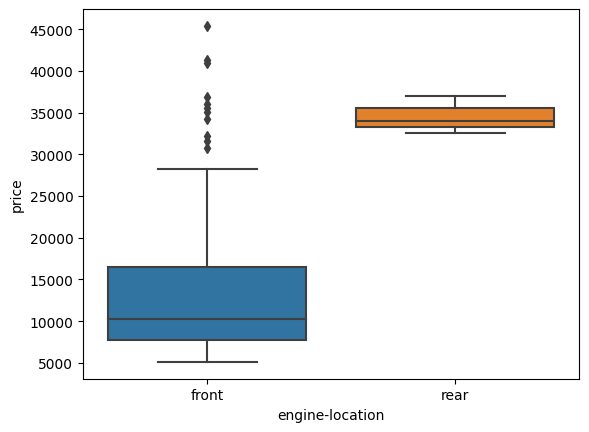

In [166]:
sns.boxplot(x="engine-location", y="price", data=df_categorical)

In [170]:
df_categorical['engine-location'].value_counts()

front    196
rear       3
Name: engine-location, dtype: int64

у нас вообще только 3 автомобиля , вряд ли это сильно повлияет на оценку

Категориальные переменные могут влиять на цену, примерно на 15 - 20 процентов, об этом нам говорит наш показатель в 80 процентов соответствия модели